## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/geno/geno_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_pubchem_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train_all = df_train_all['genotoxicity']

X_train = df_train.loc[:, df_train.columns != 'genotoxicity']
y_train = df_train['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

X_valid = df_valid.loc[:, df_valid.columns != 'genotoxicity']
y_valid = df_valid['genotoxicity']

In [6]:
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['genotoxicity']]
X_train = X_train[idxs['genotoxicity']]
X_test = X_test[idxs['genotoxicity']]
X_valid = X_valid[idxs['genotoxicity']]

In [7]:
X_train.shape

(17440, 480)

In [8]:
X_test.shape

(4984, 480)

In [9]:
X_valid.shape

(2491, 480)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [10]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(480, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [11]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [12]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=2491, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.9447384256835378, Accuracy: -8.407041078133961
Test Avg. loss: 0.9874542355537415, Accuracy: -3.125034927280259
################## EPOCH 2 ##################
Train Avg. loss: 1.4668725998029797, Accuracy: -6.115139783834278
Test Avg. loss: 1.229346752166748, Accuracy: -4.135526960856969
################## EPOCH 3 ##################
Train Avg. loss: 1.2358232459890732, Accuracy: -5.050716605950067
Test Avg. loss: 1.4258238077163696, Accuracy: -4.95629853028348
################## EPOCH 4 ##################
Train Avg. loss: 1.075410906382657, Accuracy: -4.2625593112860445
Test Avg. loss: 1.222304344177246, Accuracy: -4.106108174678438
################## EPOCH 5 ##################
Train Avg. loss: 0.9420535410762927, Accuracy: -3.562546026217362
Test Avg. loss: 0.9650136828422546, Accuracy: -3.031290341433568
################## EPOCH 6 ##################
Train Avg. loss: 0.8100834571440285, Accu

Train Avg. loss: 0.19134920198436178, Accuracy: 0.15385813091913694
Test Avg. loss: 0.19860173761844635, Accuracy: 0.1703524416058283
################## EPOCH 47 ##################
Train Avg. loss: 0.18906530456258616, Accuracy: 0.16706014948730433
Test Avg. loss: 0.19853933155536652, Accuracy: 0.17061308254135554
################## EPOCH 48 ##################
Train Avg. loss: 0.18973625211404005, Accuracy: 0.16978323252295183
Test Avg. loss: 0.19803349673748016, Accuracy: 0.1727261963467488
################## EPOCH 49 ##################
Train Avg. loss: 0.1901873442011142, Accuracy: 0.16239551040679598
Test Avg. loss: 0.2025083750486374, Accuracy: 0.15403262842275778
################## EPOCH 50 ##################
Train Avg. loss: 0.1877994049921495, Accuracy: 0.17028353096894022
Test Avg. loss: 0.19901633262634277, Accuracy: 0.16862049208176644
################## EPOCH 51 ##################
Train Avg. loss: 0.18776930048378235, Accuracy: 0.17168433528494836
Test Avg. loss: 0.197496503

Train Avg. loss: 0.16635893076794958, Accuracy: 0.26214207703842096
Test Avg. loss: 0.19267697632312775, Accuracy: 0.19510275033655256
################## EPOCH 93 ##################
Train Avg. loss: 0.16718885369530512, Accuracy: 0.2551512378368614
Test Avg. loss: 0.19400081038475037, Accuracy: 0.18957255883063406
################## EPOCH 94 ##################
Train Avg. loss: 0.164713119954691, Accuracy: 0.26162986889731893
Test Avg. loss: 0.19028301537036896, Accuracy: 0.20510336517500283
################## EPOCH 95 ##################
Train Avg. loss: 0.16156608996178032, Accuracy: 0.280740761742767
Test Avg. loss: 0.19381876289844513, Accuracy: 0.19033301681729498
################## EPOCH 96 ##################
Train Avg. loss: 0.16320875993835818, Accuracy: 0.26972350079803004
Test Avg. loss: 0.19411082565784454, Accuracy: 0.18911295997088773
################## EPOCH 97 ##################
Train Avg. loss: 0.1597948947357475, Accuracy: 0.28578005603788775
Test Avg. loss: 0.1965184509

Train Avg. loss: 0.15233902249724493, Accuracy: 0.31578748205610263
Test Avg. loss: 0.1913253664970398, Accuracy: 0.20074908509352318
################## EPOCH 139 ##################
Train Avg. loss: 0.14965091997740465, Accuracy: 0.3266619004354063
Test Avg. loss: 0.1953258514404297, Accuracy: 0.18403726901675488
################## EPOCH 140 ##################
Train Avg. loss: 0.15223725788090206, Accuracy: 0.3252720887169581
Test Avg. loss: 0.1908661127090454, Accuracy: 0.2026675018843589
################## EPOCH 141 ##################
Train Avg. loss: 0.1490319696246484, Accuracy: 0.3355289438391756
Test Avg. loss: 0.19120657444000244, Accuracy: 0.20124532945653384
################## EPOCH 142 ##################
Train Avg. loss: 0.14845890314617288, Accuracy: 0.3323452254305928
Test Avg. loss: 0.19461151957511902, Accuracy: 0.18702135628566308
################## EPOCH 143 ##################
Train Avg. loss: 0.1534345178360786, Accuracy: 0.31469235598114204
Test Avg. loss: 0.194244146

Train Avg. loss: 0.1442445651585356, Accuracy: 0.3470266379539526
Test Avg. loss: 0.19560407102108002, Accuracy: 0.18287499033992238
################## EPOCH 185 ##################
Train Avg. loss: 0.14024954576284512, Accuracy: 0.36530827202580396
Test Avg. loss: 0.19325444102287292, Accuracy: 0.19269045269545326
################## EPOCH 186 ##################
Train Avg. loss: 0.1399542296561626, Accuracy: 0.3693421626740406
Test Avg. loss: 0.19590669870376587, Accuracy: 0.181610785091456
################## EPOCH 187 ##################
Train Avg. loss: 0.14105747076896352, Accuracy: 0.3660751354057164
Test Avg. loss: 0.18985003232955933, Accuracy: 0.20691221497092582
################## EPOCH 188 ##################
Train Avg. loss: 0.13924373980235616, Accuracy: 0.37102229681046855
Test Avg. loss: 0.1929732859134674, Accuracy: 0.19386490755539132
################## EPOCH 189 ##################
Train Avg. loss: 0.14289971634472182, Accuracy: 0.3554686414395402
Test Avg. loss: 0.19324202

Train Avg. loss: 0.13277205487183474, Accuracy: 0.4013046527709018
Test Avg. loss: 0.19180984795093536, Accuracy: 0.1987251593091245
################## EPOCH 231 ##################
Train Avg. loss: 0.13679449739396024, Accuracy: 0.38444460803645186
Test Avg. loss: 0.19028924405574799, Accuracy: 0.20507738292956545
################## EPOCH 232 ##################
Train Avg. loss: 0.1344743427265128, Accuracy: 0.3956647900170412
Test Avg. loss: 0.19238059222698212, Accuracy: 0.19634091150636335
################## EPOCH 233 ##################
Train Avg. loss: 0.13463292802009014, Accuracy: 0.3902461155282573
Test Avg. loss: 0.19404104351997375, Accuracy: 0.18940444339625107
################## EPOCH 234 ##################
Train Avg. loss: 0.134127101199616, Accuracy: 0.3924513605681209
Test Avg. loss: 0.19021905958652496, Accuracy: 0.20537059513806533
################## EPOCH 235 ##################
Train Avg. loss: 0.13607265769478377, Accuracy: 0.3822585348034105
Test Avg. loss: 0.19541046

Train Avg. loss: 0.12798273240754363, Accuracy: 0.42087723766151003
Test Avg. loss: 0.19631709158420563, Accuracy: 0.17989642906342462
################## EPOCH 277 ##################
Train Avg. loss: 0.13049943798452343, Accuracy: 0.40775036697193584
Test Avg. loss: 0.19236072897911072, Accuracy: 0.19642396107618898
################## EPOCH 278 ##################
Train Avg. loss: 0.12973111846714938, Accuracy: 0.41126875284120196
Test Avg. loss: 0.19192379713058472, Accuracy: 0.19824908088492565
################## EPOCH 279 ##################
Train Avg. loss: 0.12906630986600842, Accuracy: 0.41581110865111887
Test Avg. loss: 0.19213974475860596, Accuracy: 0.1973470381252238
################## EPOCH 280 ##################
Train Avg. loss: 0.1333780974149704, Accuracy: 0.4016775755928391
Test Avg. loss: 0.19432951509952545, Accuracy: 0.18819945469167143
################## EPOCH 281 ##################
Train Avg. loss: 0.12717248895846375, Accuracy: 0.4209000487488733
Test Avg. loss: 0.193

Train Avg. loss: 0.3677988282162628, Accuracy: -0.5877352902527819
Test Avg. loss: 0.27366381883621216, Accuracy: -0.14321520394492504
################## EPOCH 23 ##################
Train Avg. loss: 0.35040424300200773, Accuracy: -0.5075842586143642
Test Avg. loss: 0.2502630650997162, Accuracy: -0.045459855020006934
################## EPOCH 24 ##################
Train Avg. loss: 0.32732548922191174, Accuracy: -0.40969050912470767
Test Avg. loss: 0.22862601280212402, Accuracy: 0.044927751613559885
################## EPOCH 25 ##################
Train Avg. loss: 0.3125747408949848, Accuracy: -0.34431088714905117
Test Avg. loss: 0.2207622528076172, Accuracy: 0.07777814809469108
################## EPOCH 26 ##################
Train Avg. loss: 0.2936498070265347, Accuracy: -0.2523263636353829
Test Avg. loss: 0.21501845121383667, Accuracy: 0.10177260450934156
################## EPOCH 27 ##################
Train Avg. loss: 0.2794316829124213, Accuracy: -0.19324550769059537
Test Avg. loss: 0.213

Train Avg. loss: 0.17772272979711, Accuracy: 0.24476998317011442
Test Avg. loss: 0.19460055232048035, Accuracy: 0.18706713988694035
################## EPOCH 69 ##################
Train Avg. loss: 0.17718107103209793, Accuracy: 0.24697029725908012
Test Avg. loss: 0.1947006732225418, Accuracy: 0.18664887534454122
################## EPOCH 70 ##################
Train Avg. loss: 0.1764642772547928, Accuracy: 0.2474688011559767
Test Avg. loss: 0.19417713582515717, Accuracy: 0.18883591309823922
################## EPOCH 71 ##################
Train Avg. loss: 0.17556114625799787, Accuracy: 0.2530798280056008
Test Avg. loss: 0.19525638222694397, Accuracy: 0.1843274044537987
################## EPOCH 72 ##################
Train Avg. loss: 0.1726838693350226, Accuracy: 0.2658345837527606
Test Avg. loss: 0.19687478244304657, Accuracy: 0.17756662226146724
################## EPOCH 73 ##################
Train Avg. loss: 0.173606415835274, Accuracy: 0.2610591916106685
Test Avg. loss: 0.19467149674892426

Train Avg. loss: 0.15915366696132408, Accuracy: 0.3186694047447917
Test Avg. loss: 0.19201400876045227, Accuracy: 0.19787226597393315
################## EPOCH 115 ##################
Train Avg. loss: 0.15251392860224833, Accuracy: 0.3440846205485264
Test Avg. loss: 0.1924673169851303, Accuracy: 0.19597858456013628
################## EPOCH 116 ##################
Train Avg. loss: 0.15529879166202232, Accuracy: 0.33539786662253424
Test Avg. loss: 0.19049350917339325, Accuracy: 0.20422405501585472
################## EPOCH 117 ##################
Train Avg. loss: 0.1592356991363969, Accuracy: 0.3194463318901172
Test Avg. loss: 0.19014644622802734, Accuracy: 0.2056739893686894
################## EPOCH 118 ##################
Train Avg. loss: 0.1536240299324413, Accuracy: 0.33913386769493764
Test Avg. loss: 0.18845701217651367, Accuracy: 0.21273145008520844
################## EPOCH 119 ##################
Train Avg. loss: 0.1565929385714042, Accuracy: 0.3292119757682068
Test Avg. loss: 0.18721413

Train Avg. loss: 0.14324654131145267, Accuracy: 0.3841375423019124
Test Avg. loss: 0.18597985804080963, Accuracy: 0.2230795864968711
################## EPOCH 161 ##################
Train Avg. loss: 0.14432787330268504, Accuracy: 0.37727768169450265
Test Avg. loss: 0.18933798372745514, Accuracy: 0.2090512236553017
################## EPOCH 162 ##################
Train Avg. loss: 0.14411289809824346, Accuracy: 0.3794193515456621
Test Avg. loss: 0.18877790868282318, Accuracy: 0.2113909309210258
################## EPOCH 163 ##################
Train Avg. loss: 0.14476876393397212, Accuracy: 0.3789229431890771
Test Avg. loss: 0.18739673495292664, Accuracy: 0.21716070707392565
################## EPOCH 164 ##################
Train Avg. loss: 0.14188357665043175, Accuracy: 0.39038563294952994
Test Avg. loss: 0.1892782598733902, Accuracy: 0.20930072990587023
################## EPOCH 165 ##################
Train Avg. loss: 0.1432323300521889, Accuracy: 0.3807072588695528
Test Avg. loss: 0.18531669

Train Avg. loss: 0.1372492632968522, Accuracy: 0.4072807261759768
Test Avg. loss: 0.18991003930568695, Accuracy: 0.20666152075082045
################## EPOCH 207 ##################
Train Avg. loss: 0.13490925468640885, Accuracy: 0.41750437685327635
Test Avg. loss: 0.18649940192699432, Accuracy: 0.2209092711151619
################## EPOCH 208 ##################
Train Avg. loss: 0.13725919554849247, Accuracy: 0.4090253852200589
Test Avg. loss: 0.18893693387508392, Accuracy: 0.21072663748778586
################## EPOCH 209 ##################
Train Avg. loss: 0.13392985485248513, Accuracy: 0.4217859360457965
Test Avg. loss: 0.1891927570104599, Accuracy: 0.2096579165899699
################## EPOCH 210 ##################
Train Avg. loss: 0.13563263481789892, Accuracy: 0.4101360266304752
Test Avg. loss: 0.19007530808448792, Accuracy: 0.20597112963620723
################## EPOCH 211 ##################
Train Avg. loss: 0.1330623439489267, Accuracy: 0.42463982150215845
Test Avg. loss: 0.18843340

Train Avg. loss: 0.12661287599267104, Accuracy: 0.45389075255806066
Test Avg. loss: 0.18821276724338531, Accuracy: 0.21375170818698197
################## EPOCH 253 ##################
Train Avg. loss: 0.1291022302903535, Accuracy: 0.44079813647773486
Test Avg. loss: 0.18889988958835602, Accuracy: 0.21088136080558473
################## EPOCH 254 ##################
Train Avg. loss: 0.13185202877545532, Accuracy: 0.43252322135049953
Test Avg. loss: 0.18884749710559845, Accuracy: 0.21110020188235112
################## EPOCH 255 ##################
Train Avg. loss: 0.12732276803517079, Accuracy: 0.4459384675188127
Test Avg. loss: 0.18847055733203888, Accuracy: 0.2126748190871739
################## EPOCH 256 ##################
Train Avg. loss: 0.13122096829689467, Accuracy: 0.43106645538508775
Test Avg. loss: 0.18567998707294464, Accuracy: 0.22433232137445236
################## EPOCH 257 ##################
Train Avg. loss: 0.1304422337766532, Accuracy: 0.4354537689092349
Test Avg. loss: 0.1867

Train Avg. loss: 0.12397165199393755, Accuracy: 0.4614226231740669
Test Avg. loss: 0.18662042915821075, Accuracy: 0.22040364533387635
################## EPOCH 299 ##################
Train Avg. loss: 0.12500257932004474, Accuracy: 0.4556214606629941
Test Avg. loss: 0.18807049095630646, Accuracy: 0.21434609504327162
################## EPOCH 300 ##################
Train Avg. loss: 0.12359048793222005, Accuracy: 0.465842926657446
Test Avg. loss: 0.1885964572429657, Accuracy: 0.21214891069078823
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 2.280422993820079, Accuracy: -8.568197139031318
Test Avg. loss: 0.5160553455352783, Accuracy: -1.1557922477481117
################## EPOCH 2 ##################
Train Avg. loss: 1.4224133439307665, Accuracy: -5.142674963862506
Test Avg. loss: 0.5353745222091675, Accuracy: -1.2364967756868777
################## EPOCH 3 ##################
Train Avg. loss: 1.423363621217491, Accuracy: -5.145346584149373
Test A

Train Avg. loss: 0.2993447173685923, Accuracy: -0.2603784662937549
Test Avg. loss: 0.21196265518665314, Accuracy: 0.11453800241906076
################## EPOCH 45 ##################
Train Avg. loss: 0.29681553446898495, Accuracy: -0.2493412272299076
Test Avg. loss: 0.208050936460495, Accuracy: 0.13087896650624598
################## EPOCH 46 ##################
Train Avg. loss: 0.2779676273573924, Accuracy: -0.1667915454186119
Test Avg. loss: 0.20967376232147217, Accuracy: 0.12409970585278896
################## EPOCH 47 ##################
Train Avg. loss: 0.27705171399743017, Accuracy: -0.16727404526511208
Test Avg. loss: 0.2089093029499054, Accuracy: 0.12729324552904697
################## EPOCH 48 ##################
Train Avg. loss: 0.2675855615495765, Accuracy: -0.12198535521847487
Test Avg. loss: 0.210341677069664, Accuracy: 0.12130953211771356
################## EPOCH 49 ##################
Train Avg. loss: 0.26175998303576975, Accuracy: -0.10065450579615944
Test Avg. loss: 0.208474799

Train Avg. loss: 0.16484095085493838, Accuracy: 0.307892319665318
Test Avg. loss: 0.19244952499866486, Accuracy: 0.1960528984486556
################## EPOCH 91 ##################
Train Avg. loss: 0.16380029323979886, Accuracy: 0.3122885961485734
Test Avg. loss: 0.19208881258964539, Accuracy: 0.1975598655437053
################## EPOCH 92 ##################
Train Avg. loss: 0.16468873832130085, Accuracy: 0.3079549660871031
Test Avg. loss: 0.1971137523651123, Accuracy: 0.17656844345983447
################## EPOCH 93 ##################
Train Avg. loss: 0.162220843299462, Accuracy: 0.31632335531479316
Test Avg. loss: 0.19537539780139923, Accuracy: 0.18383028230201037
################## EPOCH 94 ##################
Train Avg. loss: 0.1627262880767349, Accuracy: 0.3161148421813362
Test Avg. loss: 0.19344601035118103, Accuracy: 0.1918901627301336
################## EPOCH 95 ##################
Train Avg. loss: 0.16245497113270482, Accuracy: 0.31653757368086416
Test Avg. loss: 0.1908105760812759

Train Avg. loss: 0.1435048129327976, Accuracy: 0.3961711311594793
Test Avg. loss: 0.19109821319580078, Accuracy: 0.20169795661495238
################## EPOCH 137 ##################
Train Avg. loss: 0.1434311704152692, Accuracy: 0.3967827833520933
Test Avg. loss: 0.19461092352867126, Accuracy: 0.18702382822925323
################## EPOCH 138 ##################
Train Avg. loss: 0.14421512349678653, Accuracy: 0.39175653040439967
Test Avg. loss: 0.198716938495636, Accuracy: 0.1698711563151395
################## EPOCH 139 ##################
Train Avg. loss: 0.14446457431916773, Accuracy: 0.38818232848563833
Test Avg. loss: 0.19483190774917603, Accuracy: 0.18610074057530213
################## EPOCH 140 ##################
Train Avg. loss: 0.14375188092898278, Accuracy: 0.39240974309879195
Test Avg. loss: 0.1928674727678299, Accuracy: 0.19430705132734571
################## EPOCH 141 ##################
Train Avg. loss: 0.14333117736952147, Accuracy: 0.3936256516504375
Test Avg. loss: 0.18812869

Train Avg. loss: 0.13290778041756066, Accuracy: 0.4355067799147307
Test Avg. loss: 0.19056925177574158, Accuracy: 0.20390772571476734
################## EPOCH 183 ##################
Train Avg. loss: 0.13242438756418926, Accuracy: 0.44154132120492795
Test Avg. loss: 0.19162677228450775, Accuracy: 0.1994900018094804
################## EPOCH 184 ##################
Train Avg. loss: 0.13389679283773812, Accuracy: 0.4345999365508762
Test Avg. loss: 0.19367632269859314, Accuracy: 0.1909280452203641
################## EPOCH 185 ##################
Train Avg. loss: 0.1338406574443309, Accuracy: 0.4339817792975941
Test Avg. loss: 0.19493210315704346, Accuracy: 0.1856820848086983
################## EPOCH 186 ##################
Train Avg. loss: 0.1346563531534515, Accuracy: 0.43226703827887
Test Avg. loss: 0.193829745054245, Accuracy: 0.1902871850413167
################## EPOCH 187 ##################
Train Avg. loss: 0.1286301267788793, Accuracy: 0.4543408128013291
Test Avg. loss: 0.191693603992462

Train Avg. loss: 0.1259397293855674, Accuracy: 0.46842602481996426
Test Avg. loss: 0.19624492526054382, Accuracy: 0.180197913047084
################## EPOCH 229 ##################
Train Avg. loss: 0.12317199004392554, Accuracy: 0.4763983524542104
Test Avg. loss: 0.18940593302249908, Accuracy: 0.20876738105290116
################## EPOCH 230 ##################
Train Avg. loss: 0.12330666426433264, Accuracy: 0.48019141214532635
Test Avg. loss: 0.19389331340789795, Accuracy: 0.19002161105404303
################## EPOCH 231 ##################
Train Avg. loss: 0.12132463158264647, Accuracy: 0.4844955569886751
Test Avg. loss: 0.20023301243782043, Accuracy: 0.1635377880607488
################## EPOCH 232 ##################
Train Avg. loss: 0.12446366446296664, Accuracy: 0.471401170092826
Test Avg. loss: 0.19274626672267914, Accuracy: 0.19481333273915702
################## EPOCH 233 ##################
Train Avg. loss: 0.12467935488280589, Accuracy: 0.4690680844944648
Test Avg. loss: 0.19617493

Train Avg. loss: 0.11701935812504623, Accuracy: 0.5043210025810791
Test Avg. loss: 0.1979205459356308, Accuracy: 0.17319812205310892
################## EPOCH 275 ##################
Train Avg. loss: 0.12123068318749866, Accuracy: 0.48694140188405816
Test Avg. loss: 0.201429083943367, Accuracy: 0.15854130626841456
################## EPOCH 276 ##################
Train Avg. loss: 0.11723001774427665, Accuracy: 0.5015422504826711
Test Avg. loss: 0.1992579698562622, Accuracy: 0.16761110036894955
################## EPOCH 277 ##################
Train Avg. loss: 0.12153906951638034, Accuracy: 0.48458495082748687
Test Avg. loss: 0.19898971915245056, Accuracy: 0.16873166855684263
################## EPOCH 278 ##################
Train Avg. loss: 0.12004438640862486, Accuracy: 0.48966230834311686
Test Avg. loss: 0.20345936715602875, Accuracy: 0.150059900335058
################## EPOCH 279 ##################
Train Avg. loss: 0.11800423465723539, Accuracy: 0.4989940577465926
Test Avg. loss: 0.19540189

Train Avg. loss: 1.0307261339132336, Accuracy: -3.3359577435576213
Test Avg. loss: 3.009995698928833, Accuracy: -11.574087362090378
################## EPOCH 21 ##################
Train Avg. loss: 0.982574538908143, Accuracy: -3.125806640098768
Test Avg. loss: 2.3030319213867188, Accuracy: -8.6207864473666
################## EPOCH 22 ##################
Train Avg. loss: 0.9745450278987056, Accuracy: -3.1107849039151643
Test Avg. loss: 2.6989736557006836, Accuracy: -10.274810557018316
################## EPOCH 23 ##################
Train Avg. loss: 0.9678257686504419, Accuracy: -3.0841406495907897
Test Avg. loss: 1.2475602626800537, Accuracy: -4.211612751985372
################## EPOCH 24 ##################
Train Avg. loss: 0.9544604023297628, Accuracy: -3.0258785568653837
Test Avg. loss: 2.2670602798461914, Accuracy: -8.47051636837146
################## EPOCH 25 ##################
Train Avg. loss: 0.9386317246202109, Accuracy: -2.9611951264864325
Test Avg. loss: 2.040919542312622, Accurac

Train Avg. loss: 0.39468151330947876, Accuracy: -0.6506557646765702
Test Avg. loss: 0.3593537211418152, Accuracy: -0.501179937691625
################## EPOCH 67 ##################
Train Avg. loss: 0.3867257220157679, Accuracy: -0.6185588548221553
Test Avg. loss: 0.31381312012672424, Accuracy: -0.310936647661606
################## EPOCH 68 ##################
Train Avg. loss: 0.38514122410096985, Accuracy: -0.612857539220333
Test Avg. loss: 0.2845134139060974, Accuracy: -0.18853864295680478
################## EPOCH 69 ##################
Train Avg. loss: 0.37819897135098773, Accuracy: -0.582821873034626
Test Avg. loss: 0.27269962430000305, Accuracy: -0.13918724314137676
################## EPOCH 70 ##################
Train Avg. loss: 0.36367098080075305, Accuracy: -0.5218648851454358
Test Avg. loss: 0.2675016224384308, Accuracy: -0.11747294018478716
################## EPOCH 71 ##################
Train Avg. loss: 0.3617069025834401, Accuracy: -0.5111156113742432
Test Avg. loss: 0.2621284723

Train Avg. loss: 0.18085932396892188, Accuracy: 0.24735584137803132
Test Avg. loss: 0.1956842988729477, Accuracy: 0.1825398379593408
################## EPOCH 113 ##################
Train Avg. loss: 0.1810739167790482, Accuracy: 0.24718308781189496
Test Avg. loss: 0.1951981633901596, Accuracy: 0.18457071421720217
################## EPOCH 114 ##################
Train Avg. loss: 0.1805295809239581, Accuracy: 0.2503695567347873
Test Avg. loss: 0.19668136537075043, Accuracy: 0.17837460585943765
################## EPOCH 115 ##################
Train Avg. loss: 0.17396413858817972, Accuracy: 0.278826004567107
Test Avg. loss: 0.19339866936206818, Accuracy: 0.19208791708715967
################## EPOCH 116 ##################
Train Avg. loss: 0.17423024978758633, Accuracy: 0.27735803958577115
Test Avg. loss: 0.19285768270492554, Accuracy: 0.19434786191035291
################## EPOCH 117 ##################
Train Avg. loss: 0.172498080285563, Accuracy: 0.28326541250866355
Test Avg. loss: 0.194561645

Train Avg. loss: 0.14455532979058183, Accuracy: 0.40050276000272866
Test Avg. loss: 0.19109083712100983, Accuracy: 0.20172881489988537
################## EPOCH 159 ##################
Train Avg. loss: 0.1399439372446226, Accuracy: 0.41770303925451613
Test Avg. loss: 0.18833863735198975, Accuracy: 0.21322598957778138
################## EPOCH 160 ##################
Train Avg. loss: 0.13723096834576648, Accuracy: 0.42883735972338916
Test Avg. loss: 0.1892915964126587, Accuracy: 0.2092450048824187
################## EPOCH 161 ##################
Train Avg. loss: 0.14254521945680398, Accuracy: 0.4072630091363471
Test Avg. loss: 0.19242796301841736, Accuracy: 0.19614299382227307
################## EPOCH 162 ##################
Train Avg. loss: 0.14227290905040244, Accuracy: 0.4071097180712
Test Avg. loss: 0.18844527006149292, Accuracy: 0.21278050688662808
################## EPOCH 163 ##################
Train Avg. loss: 0.14235716140356616, Accuracy: 0.41026424993985955
Test Avg. loss: 0.1914927

Train Avg. loss: 0.12739035983880362, Accuracy: 0.47066342012188817
Test Avg. loss: 0.19221502542495728, Accuracy: 0.1970325284744031
################## EPOCH 205 ##################
Train Avg. loss: 0.12668916161941446, Accuracy: 0.47286112430583466
Test Avg. loss: 0.19017654657363892, Accuracy: 0.20554819528159762
################## EPOCH 206 ##################
Train Avg. loss: 0.12935990672828496, Accuracy: 0.4623058294588574
Test Avg. loss: 0.19003453850746155, Accuracy: 0.2061413976443145
################## EPOCH 207 ##################
Train Avg. loss: 0.12719428874012353, Accuracy: 0.47131121118073516
Test Avg. loss: 0.1883617341518402, Accuracy: 0.213129468648386
################## EPOCH 208 ##################
Train Avg. loss: 0.12711341708790566, Accuracy: 0.47017493402473287
Test Avg. loss: 0.18966981768608093, Accuracy: 0.2076650542076276
################## EPOCH 209 ##################
Train Avg. loss: 0.12731105558898137, Accuracy: 0.47158995521105973
Test Avg. loss: 0.192538

Train Avg. loss: 0.11935057512659958, Accuracy: 0.5041279407663353
Test Avg. loss: 0.19265756011009216, Accuracy: 0.1951839615090707
################## EPOCH 251 ##################
Train Avg. loss: 0.12128564375250236, Accuracy: 0.49628738056641997
Test Avg. loss: 0.1951475590467453, Accuracy: 0.18478206847082657
################## EPOCH 252 ##################
Train Avg. loss: 0.11899513081795927, Accuracy: 0.5055336350900521
Test Avg. loss: 0.19471636414527893, Accuracy: 0.18658333219525525
################## EPOCH 253 ##################
Train Avg. loss: 0.12217422823111217, Accuracy: 0.4940119006669254
Test Avg. loss: 0.19571249186992645, Accuracy: 0.1824220678734635
################## EPOCH 254 ##################
Train Avg. loss: 0.11975039174591286, Accuracy: 0.5021885983046335
Test Avg. loss: 0.19282545149326324, Accuracy: 0.1944825883955703
################## EPOCH 255 ##################
Train Avg. loss: 0.11787663842888846, Accuracy: 0.5099956808558915
Test Avg. loss: 0.19201000

Train Avg. loss: 0.1130759135644505, Accuracy: 0.528417228850307
Test Avg. loss: 0.19579359889030457, Accuracy: 0.18208326725210233
################## EPOCH 297 ##################
Train Avg. loss: 0.11480190799288127, Accuracy: 0.5232319194032794
Test Avg. loss: 0.19440235197544098, Accuracy: 0.18789515400715162
################## EPOCH 298 ##################
Train Avg. loss: 0.11078889462826909, Accuracy: 0.538300886873727
Test Avg. loss: 0.19542072713375092, Accuracy: 0.1836408886720352
################## EPOCH 299 ##################
Train Avg. loss: 0.11263190663379172, Accuracy: 0.5312092436848259
Test Avg. loss: 0.19366313517093658, Accuracy: 0.19098319925588547
################## EPOCH 300 ##################
Train Avg. loss: 0.11427980288863182, Accuracy: 0.5254890249859097
Test Avg. loss: 0.19654163718223572, Accuracy: 0.17895838757686433
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.9366271146940528, Accuracy: -8.36057946401439


Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 42 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 43 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 44 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 45 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 46 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.03933370539339

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 86 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 87 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 88 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 89 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 90 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.03933370539339

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 130 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 131 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 132 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 133 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 134 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 174 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 175 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 176 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 177 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 178 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 218 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 219 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 220 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 221 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 222 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 262 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 263 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 264 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 265 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705393399164
Test Avg. loss: 0.23971228301525116, Accuracy: -0.0013845329702075748
################## EPOCH 266 ##################
Train Avg. loss: 0.24342487513198766, Accuracy: -0.039333705

Train Avg. loss: 0.5301444495553935, Accuracy: -1.3124567968525485
Test Avg. loss: 0.5009244680404663, Accuracy: -1.0925837838147383
################## EPOCH 6 ##################
Train Avg. loss: 0.41761819019422425, Accuracy: -0.8032591203284125
Test Avg. loss: 0.2574252188205719, Accuracy: -0.07537939175374353
################## EPOCH 7 ##################
Train Avg. loss: 0.34472569599474745, Accuracy: -0.48068070610648767
Test Avg. loss: 0.23010429739952087, Accuracy: 0.03875223019027063
################## EPOCH 8 ##################
Train Avg. loss: 0.2953888196975757, Accuracy: -0.2523360399549616
Test Avg. loss: 0.22492682933807373, Accuracy: 0.060380800332158535
################## EPOCH 9 ##################
Train Avg. loss: 0.2662047985872943, Accuracy: -0.120930455995714
Test Avg. loss: 0.2227919101715088, Accuracy: 0.06929929274427948
################## EPOCH 10 ##################
Train Avg. loss: 0.25173571913233606, Accuracy: -0.05691687662664068
Test Avg. loss: 0.21956038475

Train Avg. loss: 0.22933831218725595, Accuracy: 0.03701345371622835
Test Avg. loss: 0.22337980568408966, Accuracy: 0.06684348336844914
################## EPOCH 52 ##################
Train Avg. loss: 0.22634954234728447, Accuracy: 0.049537787014236646
Test Avg. loss: 0.21840360760688782, Accuracy: 0.0876312008901251
################## EPOCH 53 ##################
Train Avg. loss: 0.2273017806393323, Accuracy: 0.04577104102181397
Test Avg. loss: 0.2242569625377655, Accuracy: 0.06317921444242103
################## EPOCH 54 ##################
Train Avg. loss: 0.2259283545853454, Accuracy: 0.04861303143990063
Test Avg. loss: 0.2170393168926239, Accuracy: 0.09333040221643496
################## EPOCH 55 ##################
Train Avg. loss: 0.22632195582210798, Accuracy: 0.04852652658062356
Test Avg. loss: 0.222109854221344, Accuracy: 0.07214866002167819
################## EPOCH 56 ##################
Train Avg. loss: 0.2276153781420582, Accuracy: 0.042912443525710546
Test Avg. loss: 0.2239276170

Train Avg. loss: 0.21928551274559874, Accuracy: 0.07796252893567998
Test Avg. loss: 0.21367084980010986, Accuracy: 0.10740208924610739
################## EPOCH 98 ##################
Train Avg. loss: 0.2172295820964125, Accuracy: 0.08709956885993951
Test Avg. loss: 0.2130100280046463, Accuracy: 0.11016260517196219
################## EPOCH 99 ##################
Train Avg. loss: 0.21783868709217497, Accuracy: 0.08276519926833555
Test Avg. loss: 0.2157602310180664, Accuracy: 0.09867383993360246
################## EPOCH 100 ##################
Train Avg. loss: 0.21836072105518628, Accuracy: 0.08034863952669193
Test Avg. loss: 0.21566182374954224, Accuracy: 0.09908480965646094
################## EPOCH 101 ##################
Train Avg. loss: 0.2190475236801874, Accuracy: 0.0761974315828403
Test Avg. loss: 0.21811950206756592, Accuracy: 0.08881805647443142
################## EPOCH 102 ##################
Train Avg. loss: 0.21803903642482372, Accuracy: 0.08054952304460838
Test Avg. loss: 0.223545

Train Avg. loss: 0.20899276031460953, Accuracy: 0.11676814562799938
Test Avg. loss: 0.207341268658638, Accuracy: 0.13384351942486383
################## EPOCH 144 ##################
Train Avg. loss: 0.20657564445838825, Accuracy: 0.12786364517852963
Test Avg. loss: 0.20631979405879974, Accuracy: 0.13811064486184899
################## EPOCH 145 ##################
Train Avg. loss: 0.2037375018328101, Accuracy: 0.1363248452741618
Test Avg. loss: 0.20902860164642334, Accuracy: 0.12679473774090388
################## EPOCH 146 ##################
Train Avg. loss: 0.20515400236779516, Accuracy: 0.13499280793285634
Test Avg. loss: 0.20760175585746765, Accuracy: 0.13275534960110202
################## EPOCH 147 ##################
Train Avg. loss: 0.20694449063622472, Accuracy: 0.12610855635612547
Test Avg. loss: 0.20760364830493927, Accuracy: 0.13274747013003474
################## EPOCH 148 ##################
Train Avg. loss: 0.20318629835551474, Accuracy: 0.14228801500983185
Test Avg. loss: 0.219

Train Avg. loss: 0.20375201130633827, Accuracy: 0.1400490300012645
Test Avg. loss: 0.20748013257980347, Accuracy: 0.1332634680018363
################## EPOCH 190 ##################
Train Avg. loss: 0.19895879263842936, Accuracy: 0.1581784852948089
Test Avg. loss: 0.20962375402450562, Accuracy: 0.12430852761191358
################## EPOCH 191 ##################
Train Avg. loss: 0.2004751411058527, Accuracy: 0.15185150877268705
Test Avg. loss: 0.20938493311405182, Accuracy: 0.12530619977140978
################## EPOCH 192 ##################
Train Avg. loss: 0.20059680387432322, Accuracy: 0.15206977039066918
Test Avg. loss: 0.20843493938446045, Accuracy: 0.12927475321615822
################## EPOCH 193 ##################
Train Avg. loss: 0.20274613019856777, Accuracy: 0.1418345540271414
Test Avg. loss: 0.2098785787820816, Accuracy: 0.12324401133954366
################## EPOCH 194 ##################
Train Avg. loss: 0.19949308231527552, Accuracy: 0.15535956068793305
Test Avg. loss: 0.20881

Train Avg. loss: 0.19374968580928914, Accuracy: 0.17942871215540782
Test Avg. loss: 0.20775198936462402, Accuracy: 0.1321277919402989
################## EPOCH 236 ##################
Train Avg. loss: 0.19224636243049043, Accuracy: 0.18417262635919934
Test Avg. loss: 0.2093605101108551, Accuracy: 0.1254082750679808
################## EPOCH 237 ##################
Train Avg. loss: 0.19888113894851217, Accuracy: 0.15946496186747353
Test Avg. loss: 0.2140663117170334, Accuracy: 0.10575004474685512
################## EPOCH 238 ##################
Train Avg. loss: 0.1992920539700068, Accuracy: 0.1554591862296778
Test Avg. loss: 0.2122068852186203, Accuracy: 0.11351768892030023
################## EPOCH 239 ##################
Train Avg. loss: 0.1967930425872733, Accuracy: 0.16549756649568104
Test Avg. loss: 0.21112234890460968, Accuracy: 0.11804827050987332
################## EPOCH 240 ##################
Train Avg. loss: 0.19953548709005664, Accuracy: 0.14999974199235888
Test Avg. loss: 0.2128788

Train Avg. loss: 0.1925913156334297, Accuracy: 0.18431995546840815
Test Avg. loss: 0.20970208942890167, Accuracy: 0.12398134679498918
################## EPOCH 282 ##################
Train Avg. loss: 0.19415174361877827, Accuracy: 0.1766434128831407
Test Avg. loss: 0.2072010487318039, Accuracy: 0.13442926260374355
################## EPOCH 283 ##################
Train Avg. loss: 0.19235855878600272, Accuracy: 0.18321304015188403
Test Avg. loss: 0.20729653537273407, Accuracy: 0.134030416734081
################## EPOCH 284 ##################
Train Avg. loss: 0.19130091352777168, Accuracy: 0.18777603131062284
Test Avg. loss: 0.2101948857307434, Accuracy: 0.12192267945361124
################## EPOCH 285 ##################
Train Avg. loss: 0.19175274874810333, Accuracy: 0.1846500617686726
Test Avg. loss: 0.21352942287921906, Accuracy: 0.1079928484330469
################## EPOCH 286 ##################
Train Avg. loss: 0.19123676875026235, Accuracy: 0.1880994354276673
Test Avg. loss: 0.21122221

Train Avg. loss: 0.21782366724780006, Accuracy: 0.09272664974567738
Test Avg. loss: 0.2097054272890091, Accuracy: 0.12396747334384894
################## EPOCH 28 ##################
Train Avg. loss: 0.2150653814421083, Accuracy: 0.10582485044390137
Test Avg. loss: 0.20880894362926483, Accuracy: 0.12771246247139456
################## EPOCH 29 ##################
Train Avg. loss: 0.21451711915705327, Accuracy: 0.10710483180094624
Test Avg. loss: 0.2184569239616394, Accuracy: 0.0874085458640722
################## EPOCH 30 ##################
Train Avg. loss: 0.21631640870205676, Accuracy: 0.09825244186811748
Test Avg. loss: 0.2127450853586197, Accuracy: 0.11126933896404578
################## EPOCH 31 ##################
Train Avg. loss: 0.21466716797682492, Accuracy: 0.1053281611272469
Test Avg. loss: 0.21914434432983398, Accuracy: 0.08453690368948352
################## EPOCH 32 ##################
Train Avg. loss: 0.2147355076387851, Accuracy: 0.10510616686997402
Test Avg. loss: 0.21465799212

Train Avg. loss: 0.1961755337615083, Accuracy: 0.1801872875012764
Test Avg. loss: 0.20538330078125, Accuracy: 0.14202288671092278
################## EPOCH 74 ##################
Train Avg. loss: 0.19608200776533488, Accuracy: 0.18352043006307445
Test Avg. loss: 0.2104777842760086, Accuracy: 0.12074088376990189
################## EPOCH 75 ##################
Train Avg. loss: 0.1957746360206256, Accuracy: 0.1818151506361213
Test Avg. loss: 0.20589321851730347, Accuracy: 0.1398926256548687
################## EPOCH 76 ##################
Train Avg. loss: 0.19728432606606588, Accuracy: 0.17887171377477565
Test Avg. loss: 0.21309606730937958, Accuracy: 0.10980316862856032
################## EPOCH 77 ##################
Train Avg. loss: 0.19827062419078645, Accuracy: 0.1728121444519857
Test Avg. loss: 0.20577840507030487, Accuracy: 0.14037232575910152
################## EPOCH 78 ##################
Train Avg. loss: 0.1974329987037791, Accuracy: 0.17837229935732948
Test Avg. loss: 0.209151968359947

Train Avg. loss: 0.17972361927267408, Accuracy: 0.24768305135528787
Test Avg. loss: 0.19573597609996796, Accuracy: 0.18232396579519317
################## EPOCH 120 ##################
Train Avg. loss: 0.1810147536605814, Accuracy: 0.24552892687181577
Test Avg. loss: 0.19804763793945312, Accuracy: 0.17266713093061847
################## EPOCH 121 ##################
Train Avg. loss: 0.18207120248218522, Accuracy: 0.2388746352458152
Test Avg. loss: 0.20202408730983734, Accuracy: 0.15605577995541786
################## EPOCH 122 ##################
Train Avg. loss: 0.18016921554821252, Accuracy: 0.24516057255028664
Test Avg. loss: 0.2034095674753189, Accuracy: 0.15026801062544037
################## EPOCH 123 ##################
Train Avg. loss: 0.17693411031343642, Accuracy: 0.26013138204842573
Test Avg. loss: 0.20188772678375244, Accuracy: 0.15662532316896827
################## EPOCH 124 ##################
Train Avg. loss: 0.17849073722197192, Accuracy: 0.253317210687473
Test Avg. loss: 0.2005

Train Avg. loss: 0.17127437982028418, Accuracy: 0.28294089657167076
Test Avg. loss: 0.20038126409053802, Accuracy: 0.16291855856608695
################## EPOCH 166 ##################
Train Avg. loss: 0.1689562165062793, Accuracy: 0.2932501395022492
Test Avg. loss: 0.19684270024299622, Accuracy: 0.17770065648391387
################## EPOCH 167 ##################
Train Avg. loss: 0.17012812719292883, Accuracy: 0.2892316371028011
Test Avg. loss: 0.19995057582855225, Accuracy: 0.1647176784354586
################## EPOCH 168 ##################
Train Avg. loss: 0.17552144841773668, Accuracy: 0.2697064774472671
Test Avg. loss: 0.20034895837306976, Accuracy: 0.16305351121496026
################## EPOCH 169 ##################
Train Avg. loss: 0.16965177067874992, Accuracy: 0.28839714660273935
Test Avg. loss: 0.19582413136959076, Accuracy: 0.18195568260377626
################## EPOCH 170 ##################
Train Avg. loss: 0.17144128750928128, Accuracy: 0.2817062729050678
Test Avg. loss: 0.20076

Train Avg. loss: 0.16549962742702803, Accuracy: 0.30825088883116886
Test Avg. loss: 0.19614745676517487, Accuracy: 0.18060504869682437
################## EPOCH 212 ##################
Train Avg. loss: 0.16188687156804288, Accuracy: 0.3214326945706486
Test Avg. loss: 0.19617782533168793, Accuracy: 0.18047817944869493
################## EPOCH 213 ##################
Train Avg. loss: 0.16328349910730863, Accuracy: 0.3155579103413851
Test Avg. loss: 0.19802217185497284, Accuracy: 0.17277357639115465
################## EPOCH 214 ##################
Train Avg. loss: 0.1654897858082813, Accuracy: 0.3054726745859268
Test Avg. loss: 0.19997161626815796, Accuracy: 0.1646298161939027
################## EPOCH 215 ##################
Train Avg. loss: 0.16606748044273278, Accuracy: 0.3042696725372725
Test Avg. loss: 0.20272664725780487, Accuracy: 0.1531209140432157
################## EPOCH 216 ##################
Train Avg. loss: 0.16693145303178009, Accuracy: 0.30053571649252825
Test Avg. loss: 0.199670

Train Avg. loss: 0.15840135487544277, Accuracy: 0.3356747308163981
Test Avg. loss: 0.19880206882953644, Accuracy: 0.16951555335645552
################## EPOCH 258 ##################
Train Avg. loss: 0.16112083223831913, Accuracy: 0.3205832860620476
Test Avg. loss: 0.19801877439022064, Accuracy: 0.17278769771253177
################## EPOCH 259 ##################
Train Avg. loss: 0.16235897717249653, Accuracy: 0.3204405169496836
Test Avg. loss: 0.198884978890419, Accuracy: 0.16916920381496137
################## EPOCH 260 ##################
Train Avg. loss: 0.16054218724696306, Accuracy: 0.3299549940103059
Test Avg. loss: 0.19564808905124664, Accuracy: 0.18269107202401236
################## EPOCH 261 ##################
Train Avg. loss: 0.15784737968096768, Accuracy: 0.33755838351397194
Test Avg. loss: 0.20141972601413727, Accuracy: 0.15858046464676145
################## EPOCH 262 ##################
Train Avg. loss: 0.16061094174854948, Accuracy: 0.32631072124094246
Test Avg. loss: 0.19833

Train Avg. loss: 1.5640030183653901, Accuracy: -5.588344267534768
Test Avg. loss: 0.7806196808815002, Accuracy: -2.2609947970922515
################## EPOCH 4 ##################
Train Avg. loss: 1.5004658733589062, Accuracy: -5.333199491869581
Test Avg. loss: 1.4903401136398315, Accuracy: -5.225811847917902
################## EPOCH 5 ##################
Train Avg. loss: 1.4131441755571228, Accuracy: -4.984093673735391
Test Avg. loss: 1.171497106552124, Accuracy: -3.8938635128206727
################## EPOCH 6 ##################
Train Avg. loss: 1.3726791851762412, Accuracy: -4.808384671773364
Test Avg. loss: 2.8304011821746826, Accuracy: -10.823841084634648
################## EPOCH 7 ##################
Train Avg. loss: 1.3228324617164722, Accuracy: -4.574850020042847
Test Avg. loss: 1.4471863508224487, Accuracy: -5.045539309395629
################## EPOCH 8 ##################
Train Avg. loss: 1.2241220422413037, Accuracy: -4.169469062046496
Test Avg. loss: 1.933850884437561, Accuracy: -7

Train Avg. loss: 0.2143134360296139, Accuracy: 0.11258853990429782
Test Avg. loss: 0.2063886970281601, Accuracy: 0.13782280542548875
################## EPOCH 50 ##################
Train Avg. loss: 0.21191290334083032, Accuracy: 0.12200507682614432
Test Avg. loss: 0.2098880410194397, Accuracy: 0.12320450984385822
################## EPOCH 51 ##################
Train Avg. loss: 0.21211434317671735, Accuracy: 0.12144860171815397
Test Avg. loss: 0.20852622389793396, Accuracy: 0.1288934388446854
################## EPOCH 52 ##################
Train Avg. loss: 0.20957584700722626, Accuracy: 0.13189840388155685
Test Avg. loss: 0.20700523257255554, Accuracy: 0.13524730368541416
################## EPOCH 53 ##################
Train Avg. loss: 0.20644441257784332, Accuracy: 0.1446230799611118
Test Avg. loss: 0.20566245913505554, Accuracy: 0.14085664354311567
################## EPOCH 54 ##################
Train Avg. loss: 0.21043253258086633, Accuracy: 0.12925688574320968
Test Avg. loss: 0.210652664

Train Avg. loss: 0.17641302122586017, Accuracy: 0.2671200713722231
Test Avg. loss: 0.19009236991405487, Accuracy: 0.20589982352558633
################## EPOCH 96 ##################
Train Avg. loss: 0.17662997165883798, Accuracy: 0.26779636811436225
Test Avg. loss: 0.1890401691198349, Accuracy: 0.2102953412352211
################## EPOCH 97 ##################
Train Avg. loss: 0.1747546909727912, Accuracy: 0.275176423145658
Test Avg. loss: 0.19383978843688965, Accuracy: 0.19024520951382295
################## EPOCH 98 ##################
Train Avg. loss: 0.17360336198538973, Accuracy: 0.2798604151020971
Test Avg. loss: 0.18944980204105377, Accuracy: 0.2085841088987508
################## EPOCH 99 ##################
Train Avg. loss: 0.1779460832476616, Accuracy: 0.261091599181931
Test Avg. loss: 0.19267120957374573, Accuracy: 0.19512689319050525
################## EPOCH 100 ##################
Train Avg. loss: 0.17782527802215106, Accuracy: 0.262408300042945
Test Avg. loss: 0.1930438131093979

Train Avg. loss: 0.15469494785951532, Accuracy: 0.35472414927214013
Test Avg. loss: 0.18578019738197327, Accuracy: 0.22391369004011863
################## EPOCH 142 ##################
Train Avg. loss: 0.15587611302085544, Accuracy: 0.3502908739755986
Test Avg. loss: 0.1889520287513733, Accuracy: 0.21066350413149382
################## EPOCH 143 ##################
Train Avg. loss: 0.15752573365318603, Accuracy: 0.3451675995267344
Test Avg. loss: 0.19054843485355377, Accuracy: 0.20399461988248913
################## EPOCH 144 ##################
Train Avg. loss: 0.15392894470605298, Accuracy: 0.3608264677717401
Test Avg. loss: 0.1848500519990921, Accuracy: 0.2277993031460538
################## EPOCH 145 ##################
Train Avg. loss: 0.15582332608924396, Accuracy: 0.3514965869441461
Test Avg. loss: 0.187888503074646, Accuracy: 0.21510632332177315
################## EPOCH 146 ##################
Train Avg. loss: 0.151231839173082, Accuracy: 0.3710862537463214
Test Avg. loss: 0.19471931457

Train Avg. loss: 0.14400992429126863, Accuracy: 0.400855514033493
Test Avg. loss: 0.18914780020713806, Accuracy: 0.2098456947826286
################## EPOCH 188 ##################
Train Avg. loss: 0.1453594485486763, Accuracy: 0.39332987448125073
Test Avg. loss: 0.18761804699897766, Accuracy: 0.21623613078893422
################## EPOCH 189 ##################
Train Avg. loss: 0.14994432777166367, Accuracy: 0.37581378631915163
Test Avg. loss: 0.18812298774719238, Accuracy: 0.21412680251607852
################## EPOCH 190 ##################
Train Avg. loss: 0.14596570396552916, Accuracy: 0.39165546183182565
Test Avg. loss: 0.18706369400024414, Accuracy: 0.21855191836323473
################## EPOCH 191 ##################
Train Avg. loss: 0.14788078581509384, Accuracy: 0.38642164042364835
Test Avg. loss: 0.18624265491962433, Accuracy: 0.22198180948355395
################## EPOCH 192 ##################
Train Avg. loss: 0.1458017929740574, Accuracy: 0.39423845421995496
Test Avg. loss: 0.1855

Train Avg. loss: 0.13946039456388223, Accuracy: 0.4187432890998108
Test Avg. loss: 0.18254302442073822, Accuracy: 0.2374367919050876
################## EPOCH 234 ##################
Train Avg. loss: 0.13842827060084412, Accuracy: 0.4251686379901759
Test Avg. loss: 0.18007980287075043, Accuracy: 0.24772674842816533
################## EPOCH 235 ##################
Train Avg. loss: 0.1382470540162446, Accuracy: 0.4238089787173494
Test Avg. loss: 0.189206063747406, Accuracy: 0.20960228537097125
################## EPOCH 236 ##################
Train Avg. loss: 0.13953960098434184, Accuracy: 0.41839763789468065
Test Avg. loss: 0.1853378266096115, Accuracy: 0.22576161811867312
################## EPOCH 237 ##################
Train Avg. loss: 0.13534203625243643, Accuracy: 0.437665696207093
Test Avg. loss: 0.18523098528385162, Accuracy: 0.22620803850932036
################## EPOCH 238 ##################
Train Avg. loss: 0.13379962925893674, Accuracy: 0.4418839563799316
Test Avg. loss: 0.1874222457

Train Avg. loss: 0.13528827405062274, Accuracy: 0.4362145221569826
Test Avg. loss: 0.18178017437458038, Accuracy: 0.24062357823668967
################## EPOCH 280 ##################
Train Avg. loss: 0.13404682591773462, Accuracy: 0.4425751941724274
Test Avg. loss: 0.18200135231018066, Accuracy: 0.23969960958906622
################## EPOCH 281 ##################
Train Avg. loss: 0.13320010177035263, Accuracy: 0.4448577319814324
Test Avg. loss: 0.18272508680820465, Accuracy: 0.23667618423525782
################## EPOCH 282 ##################
Train Avg. loss: 0.13310460632909898, Accuracy: 0.4447261108511233
Test Avg. loss: 0.18540333211421967, Accuracy: 0.22548803596405131
################## EPOCH 283 ##################
Train Avg. loss: 0.1367853241770164, Accuracy: 0.43086314830596506
Test Avg. loss: 0.18446356058120728, Accuracy: 0.2294138486412124
################## EPOCH 284 ##################
Train Avg. loss: 0.13331100603808527, Accuracy: 0.44598423816691485
Test Avg. loss: 0.18454

Train Avg. loss: 0.24369052943833378, Accuracy: -0.04022347989395749
Test Avg. loss: 0.23969613015651703, Accuracy: -0.00131705768445034
################## EPOCH 25 ##################
Train Avg. loss: 0.24368668612810448, Accuracy: -0.040204786483088985
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 26 ##################
Train Avg. loss: 0.24368331690720463, Accuracy: -0.040189427641884226
Test Avg. loss: 0.23969635367393494, Accuracy: -0.001317977221733324
################## EPOCH 27 ##################
Train Avg. loss: 0.24368356793025217, Accuracy: -0.04019073967581631
Test Avg. loss: 0.23969654738903046, Accuracy: -0.001318902678086653
################## EPOCH 28 ##################
Train Avg. loss: 0.24368352675383245, Accuracy: -0.040198186135971606
Test Avg. loss: 0.23969610035419464, Accuracy: -0.0013169168808053744
################## EPOCH 29 ##################
Train Avg. loss: 0.2436855091961152, Accuracy: -0.040201735913329026
Te

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 70 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 71 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 72 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 73 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 74 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
T

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 114 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 115 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 116 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 117 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 118 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 158 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 159 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 160 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 161 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 162 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 202 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 203 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 204 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 205 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 206 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 246 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 247 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 248 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 249 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 250 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.24368326750096925, Accuracy: -0.04019095950068906
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 290 ##################
Train Avg. loss: 0.24368326890906064, Accuracy: -0.04019097100745999
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 291 ##################
Train Avg. loss: 0.2436832703308228, Accuracy: -0.040190978738292034
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 292 ##################
Train Avg. loss: 0.2436832703308228, Accuracy: -0.040190978738292034
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 293 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 294 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.24338504726633484, Accuracy: -0.017945854263765788
Test Avg. loss: 0.23978134989738464, Accuracy: -0.0016730668541216076
################## EPOCH 35 ##################
Train Avg. loss: 0.24338015223488266, Accuracy: -0.017845799646282037
Test Avg. loss: 0.23983851075172424, Accuracy: -0.0019119134519987036
################## EPOCH 36 ##################
Train Avg. loss: 0.24349453987983558, Accuracy: -0.018701038706422923
Test Avg. loss: 0.2379687875509262, Accuracy: 0.005898704739933591
################## EPOCH 37 ##################
Train Avg. loss: 0.24336596420068882, Accuracy: -0.01781143655581665
Test Avg. loss: 0.2397979348897934, Accuracy: -0.0017424104900427562
################## EPOCH 38 ##################
Train Avg. loss: 0.2434302004320281, Accuracy: -0.018037434044501637
Test Avg. loss: 0.23977985978126526, Accuracy: -0.0016668487415358868
################## EPOCH 39 ##################
Train Avg. loss: 0.24344616959164866, Accuracy: -0.018122887011137352
T

Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 80 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 81 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 82 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 83 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 84 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0

Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 125 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 126 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 127 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 128 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 129 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. lo

Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 170 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 171 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 172 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 173 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 174 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. lo

Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 215 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 216 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 217 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 218 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 219 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. lo

Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 260 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 261 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 262 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 263 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. loss: 0.2397792637348175, Accuracy: -0.001664380801428278
################## EPOCH 264 ##################
Train Avg. loss: 0.243447907105252, Accuracy: -0.018129875233641134
Test Avg. lo

Train Avg. loss: 1.0177296604553279, Accuracy: -3.375488014834226
Test Avg. loss: 0.4428292512893677, Accuracy: -0.8498940738823515
################## EPOCH 5 ##################
Train Avg. loss: 0.7321103906979526, Accuracy: -2.1197236907270347
Test Avg. loss: 0.3585132956504822, Accuracy: -0.49766910779791607
################## EPOCH 6 ##################
Train Avg. loss: 0.5640234146675054, Accuracy: -1.405266923622017
Test Avg. loss: 0.30308398604393005, Accuracy: -0.2661163211533961
################## EPOCH 7 ##################
Train Avg. loss: 0.42436962297363, Accuracy: -0.7892593447289492
Test Avg. loss: 0.2567388713359833, Accuracy: -0.07251207182905928
################## EPOCH 8 ##################
Train Avg. loss: 0.34387125912373956, Accuracy: -0.44221524829322456
Test Avg. loss: 0.26508915424346924, Accuracy: -0.10739506163793977
################## EPOCH 9 ##################
Train Avg. loss: 0.29729361995293274, Accuracy: -0.2399211612273043
Test Avg. loss: 0.2618402242660522

Train Avg. loss: 0.21417605463605727, Accuracy: 0.10570903092679888
Test Avg. loss: 0.20712719857692719, Accuracy: 0.13473774883020717
################## EPOCH 51 ##################
Train Avg. loss: 0.21438382250549148, Accuracy: 0.10853747588070088
Test Avg. loss: 0.21117815375328064, Accuracy: 0.11781519876421731
################## EPOCH 52 ##################
Train Avg. loss: 0.2165900467738618, Accuracy: 0.09767231018255546
Test Avg. loss: 0.21515820920467377, Accuracy: 0.10118870283090964
################## EPOCH 53 ##################
Train Avg. loss: 0.21659275867643146, Accuracy: 0.09791614297929936
Test Avg. loss: 0.210765540599823, Accuracy: 0.11953876927375817
################## EPOCH 54 ##################
Train Avg. loss: 0.2154783120338064, Accuracy: 0.10348249107138564
Test Avg. loss: 0.21704135835170746, Accuracy: 0.09332196634332157
################## EPOCH 55 ##################
Train Avg. loss: 0.2144612917934891, Accuracy: 0.10761552593000874
Test Avg. loss: 0.213762566

Train Avg. loss: 0.2067914917847536, Accuracy: 0.13961662585566076
Test Avg. loss: 0.20551861822605133, Accuracy: 0.1414574734334425
################## EPOCH 97 ##################
Train Avg. loss: 0.204196060878517, Accuracy: 0.14738622029978432
Test Avg. loss: 0.21021291613578796, Accuracy: 0.1218473903554238
################## EPOCH 98 ##################
Train Avg. loss: 0.20697371944458814, Accuracy: 0.136199784159161
Test Avg. loss: 0.21102295815944672, Accuracy: 0.11846347218448505
################## EPOCH 99 ##################
Train Avg. loss: 0.20754044932605575, Accuracy: 0.1342734221491541
Test Avg. loss: 0.20724530518054962, Accuracy: 0.13424446916303112
################## EPOCH 100 ##################
Train Avg. loss: 0.20739470444021435, Accuracy: 0.13449169941591577
Test Avg. loss: 0.210007444024086, Accuracy: 0.12270581068242536
################## EPOCH 101 ##################
Train Avg. loss: 0.20692050348233132, Accuracy: 0.13660016446239065
Test Avg. loss: 0.209387630224

Train Avg. loss: 0.1988373052356017, Accuracy: 0.16892913346530172
Test Avg. loss: 0.20672409236431122, Accuracy: 0.13642172500866834
################## EPOCH 143 ##################
Train Avg. loss: 0.20010477859173378, Accuracy: 0.16477462777435573
Test Avg. loss: 0.20404018461704254, Accuracy: 0.14763365206146928
################## EPOCH 144 ##################
Train Avg. loss: 0.20339929954196415, Accuracy: 0.15204688132387842
Test Avg. loss: 0.20803135633468628, Accuracy: 0.1309607691924377
################## EPOCH 145 ##################
Train Avg. loss: 0.19949126085878288, Accuracy: 0.16917018176493648
Test Avg. loss: 0.20858608186244965, Accuracy: 0.12864334861725357
################## EPOCH 146 ##################
Train Avg. loss: 0.20488929454862637, Accuracy: 0.1455148414165477
Test Avg. loss: 0.20641252398490906, Accuracy: 0.13772332275952748
################## EPOCH 147 ##################
Train Avg. loss: 0.20149534184784784, Accuracy: 0.15927922794348667
Test Avg. loss: 0.20

Train Avg. loss: 0.19561675843531198, Accuracy: 0.18480105112312242
Test Avg. loss: 0.21833758056163788, Accuracy: 0.08790708803919811
################## EPOCH 188 ##################
Train Avg. loss: 0.1949431803757257, Accuracy: 0.18708576644793948
Test Avg. loss: 0.20417839288711548, Accuracy: 0.14705626722354703
################## EPOCH 189 ##################
Train Avg. loss: 0.19729183858981097, Accuracy: 0.1755942706275891
Test Avg. loss: 0.19932982325553894, Accuracy: 0.16731094776751854
################## EPOCH 190 ##################
Train Avg. loss: 0.19860855250680534, Accuracy: 0.17029386728305945
Test Avg. loss: 0.2113531529903412, Accuracy: 0.11708408463942066
################## EPOCH 191 ##################
Train Avg. loss: 0.20079142192419427, Accuracy: 0.16062529952046362
Test Avg. loss: 0.21538987755775452, Accuracy: 0.10022086741534508
################## EPOCH 192 ##################
Train Avg. loss: 0.19666412750082293, Accuracy: 0.17907924912382325
Test Avg. loss: 0.21

Train Avg. loss: 0.20082810347097635, Accuracy: 0.1641431029835464
Test Avg. loss: 0.21325695514678955, Accuracy: 0.1091310709959562
################## EPOCH 234 ##################
Train Avg. loss: 0.2025468444084599, Accuracy: 0.15356999262690094
Test Avg. loss: 0.21242722868919373, Accuracy: 0.1125971133888547
################## EPOCH 235 ##################
Train Avg. loss: 0.20025183173426747, Accuracy: 0.1658350582402211
Test Avg. loss: 0.2130328267812729, Accuracy: 0.11006732990026924
################## EPOCH 236 ##################
Train Avg. loss: 0.20277094590837938, Accuracy: 0.15283753458403912
Test Avg. loss: 0.2120019495487213, Accuracy: 0.11437380421829102
################## EPOCH 237 ##################
Train Avg. loss: 0.1993744691466763, Accuracy: 0.16982854383164542
Test Avg. loss: 0.2171202003955841, Accuracy: 0.09299260164153089
################## EPOCH 238 ##################
Train Avg. loss: 0.19622555413167841, Accuracy: 0.1818839605531074
Test Avg. loss: 0.211132436

Train Avg. loss: 0.1933627682228158, Accuracy: 0.192379193227205
Test Avg. loss: 0.22117866575717926, Accuracy: 0.07603860081407754
################## EPOCH 280 ##################
Train Avg. loss: 0.1968654879253276, Accuracy: 0.17707312953334314
Test Avg. loss: 0.2114786058664322, Accuracy: 0.11656005759483057
################## EPOCH 281 ##################
Train Avg. loss: 0.19639033111777618, Accuracy: 0.18126070556564913
Test Avg. loss: 0.2104058712720871, Accuracy: 0.12104134142338174
################## EPOCH 282 ##################
Train Avg. loss: 0.1924266528039083, Accuracy: 0.19307000835401972
Test Avg. loss: 0.20603613555431366, Accuracy: 0.13929566722315867
################## EPOCH 283 ##################
Train Avg. loss: 0.19388480103799027, Accuracy: 0.19160573539542283
Test Avg. loss: 0.20769378542900085, Accuracy: 0.13237092106874881
################## EPOCH 284 ##################
Train Avg. loss: 0.1918889692556249, Accuracy: 0.1995459807207588
Test Avg. loss: 0.20539373

Train Avg. loss: 0.23044994581436765, Accuracy: 0.044809907916465046
Test Avg. loss: 0.21648633480072021, Accuracy: 0.09564049436844946
################## EPOCH 26 ##################
Train Avg. loss: 0.2308061626078426, Accuracy: 0.04276900174319871
Test Avg. loss: 0.21840907633304596, Accuracy: 0.08760841507032557
################## EPOCH 27 ##################
Train Avg. loss: 0.22863095005353293, Accuracy: 0.05254223043139752
Test Avg. loss: 0.21544843912124634, Accuracy: 0.0999762961748023
################## EPOCH 28 ##################
Train Avg. loss: 0.22694681995156882, Accuracy: 0.0594550973506009
Test Avg. loss: 0.21964344382286072, Accuracy: 0.08245185692322599
################## EPOCH 29 ##################
Train Avg. loss: 0.2248277446066124, Accuracy: 0.0680478431891342
Test Avg. loss: 0.2149174064397812, Accuracy: 0.10219471784074519
################## EPOCH 30 ##################
Train Avg. loss: 0.22503199136775473, Accuracy: 0.06726339308720948
Test Avg. loss: 0.213699743

Train Avg. loss: 0.20770323578862177, Accuracy: 0.13895442997592533
Test Avg. loss: 0.20669329166412354, Accuracy: 0.13655046868139475
################## EPOCH 72 ##################
Train Avg. loss: 0.20553594525309576, Accuracy: 0.14823528048644277
Test Avg. loss: 0.2064642608165741, Accuracy: 0.13750713228428046
################## EPOCH 73 ##################
Train Avg. loss: 0.20574716856514197, Accuracy: 0.1472390245982058
Test Avg. loss: 0.20495611429214478, Accuracy: 0.14380738553645478
################## EPOCH 74 ##################
Train Avg. loss: 0.20391412435666376, Accuracy: 0.1538410177412224
Test Avg. loss: 0.2071736603975296, Accuracy: 0.13454376231069543
################## EPOCH 75 ##################
Train Avg. loss: 0.20502003833003665, Accuracy: 0.15005600782518366
Test Avg. loss: 0.20589759945869446, Accuracy: 0.13987432570456637
################## EPOCH 76 ##################
Train Avg. loss: 0.20388216870850412, Accuracy: 0.1557837613245318
Test Avg. loss: 0.209382727

Train Avg. loss: 0.19232011543235916, Accuracy: 0.20174915327725898
Test Avg. loss: 0.19820766150951385, Accuracy: 0.1719986920607599
################## EPOCH 118 ##################
Train Avg. loss: 0.19189233602820963, Accuracy: 0.20503458676930356
Test Avg. loss: 0.19958680868148804, Accuracy: 0.1662373481229844
################## EPOCH 119 ##################
Train Avg. loss: 0.19274789267692014, Accuracy: 0.19994317335147035
Test Avg. loss: 0.20032602548599243, Accuracy: 0.16314931241728992
################## EPOCH 120 ##################
Train Avg. loss: 0.19055532890817392, Accuracy: 0.20940399197840182
Test Avg. loss: 0.19756366312503815, Accuracy: 0.1746890103830444
################## EPOCH 121 ##################
Train Avg. loss: 0.18805307236270627, Accuracy: 0.21739907799137662
Test Avg. loss: 0.1974538266658783, Accuracy: 0.1751478039503075
################## EPOCH 122 ##################
Train Avg. loss: 0.19013356406619583, Accuracy: 0.2106503756460395
Test Avg. loss: 0.19617

Train Avg. loss: 0.17749927106542865, Accuracy: 0.2635230970074777
Test Avg. loss: 0.19446736574172974, Accuracy: 0.18762349553409563
################## EPOCH 164 ##################
Train Avg. loss: 0.17719475525444833, Accuracy: 0.2630008377318404
Test Avg. loss: 0.19722409546375275, Accuracy: 0.17610748489757566
################## EPOCH 165 ##################
Train Avg. loss: 0.17356235841694084, Accuracy: 0.2795815811542887
Test Avg. loss: 0.1915273219347, Accuracy: 0.19990539850784173
################## EPOCH 166 ##################
Train Avg. loss: 0.17695727868788486, Accuracy: 0.2642548731587361
Test Avg. loss: 0.19766172766685486, Accuracy: 0.17427925781456377
################## EPOCH 167 ##################
Train Avg. loss: 0.17864255801491116, Accuracy: 0.25870834041352764
Test Avg. loss: 0.19709841907024384, Accuracy: 0.17663246521262999
################## EPOCH 168 ##################
Train Avg. loss: 0.17897293749062912, Accuracy: 0.25706222764001196
Test Avg. loss: 0.1937077

Train Avg. loss: 0.18551993607610895, Accuracy: 0.2284942080202711
Test Avg. loss: 0.19850803911685944, Accuracy: 0.17074385390678593
################## EPOCH 210 ##################
Train Avg. loss: 0.18174158209475919, Accuracy: 0.24488160699621672
Test Avg. loss: 0.20030510425567627, Accuracy: 0.16323667526035956
################## EPOCH 211 ##################
Train Avg. loss: 0.17886111690946246, Accuracy: 0.25726333938991924
Test Avg. loss: 0.19626262784004211, Accuracy: 0.18012391660747062
################## EPOCH 212 ##################
Train Avg. loss: 0.17793324789491252, Accuracy: 0.26103062188334003
Test Avg. loss: 0.19764116406440735, Accuracy: 0.17436514761218558
################## EPOCH 213 ##################
Train Avg. loss: 0.17440930268038873, Accuracy: 0.27720668344722066
Test Avg. loss: 0.19743512570858002, Accuracy: 0.17522590874093236
################## EPOCH 214 ##################
Train Avg. loss: 0.1763006387197453, Accuracy: 0.2694085037863762
Test Avg. loss: 0.19

Train Avg. loss: 0.1685965362990248, Accuracy: 0.29966020119517106
Test Avg. loss: 0.19281786680221558, Accuracy: 0.19451411846977917
################## EPOCH 256 ##################
Train Avg. loss: 0.17357261241346167, Accuracy: 0.2756113096751257
Test Avg. loss: 0.1934066265821457, Accuracy: 0.19205476252155207
################## EPOCH 257 ##################
Train Avg. loss: 0.16735310830931732, Accuracy: 0.30546920351558216
Test Avg. loss: 0.1934143751859665, Accuracy: 0.19202236487983193
################## EPOCH 258 ##################
Train Avg. loss: 0.17846426713293878, Accuracy: 0.2580671399655526
Test Avg. loss: 0.19281914830207825, Accuracy: 0.1945088807632449
################## EPOCH 259 ##################
Train Avg. loss: 0.17186410984267358, Accuracy: 0.2850956745008575
Test Avg. loss: 0.19566868245601654, Accuracy: 0.1826051100810555
################## EPOCH 260 ##################
Train Avg. loss: 0.1765978815762893, Accuracy: 0.2675501956276319
Test Avg. loss: 0.193074345

Train Avg. loss: 142.72550403568724, Accuracy: -593.0147820364234
Test Avg. loss: 1.0825484991073608, Accuracy: -3.522285296530497
################## EPOCH 2 ##################
Train Avg. loss: 0.3812372799039981, Accuracy: -0.6452913459651752
Test Avg. loss: 0.24029479920864105, Accuracy: -0.0038179699847820103
################## EPOCH 3 ##################
Train Avg. loss: 0.24599165346370924, Accuracy: -0.04904285834548321
Test Avg. loss: 0.23949994146823883, Accuracy: -0.0004975438919767594
################## EPOCH 4 ##################
Train Avg. loss: 0.24444964879423106, Accuracy: -0.04390489507055828
Test Avg. loss: 0.23952442407608032, Accuracy: -0.0005997572808782436
################## EPOCH 5 ##################
Train Avg. loss: 0.24747622168939049, Accuracy: -0.05683595955564459
Test Avg. loss: 0.23955413699150085, Accuracy: -0.0007239291632077371
################## EPOCH 6 ##################
Train Avg. loss: 0.24366054242357202, Accuracy: -0.040140500120494076
Test Avg. loss:

Train Avg. loss: 0.24522006622421633, Accuracy: -0.047905555989966764
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 47 ##################
Train Avg. loss: 0.2452200761902223, Accuracy: -0.04790562254224777
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 48 ##################
Train Avg. loss: 0.24522007891070952, Accuracy: -0.04790563678888837
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 49 ##################
Train Avg. loss: 0.24522008355877814, Accuracy: -0.047905663705081716
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 50 ##################
Train Avg. loss: 0.24522008647065643, Accuracy: -0.04790568054639082
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 51 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test 

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 92 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 93 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 94 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 95 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 96 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test A

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 137 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 138 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 139 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 140 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 141 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
T

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 182 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 183 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 184 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 185 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 186 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
T

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 227 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 228 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 229 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 230 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 231 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
T

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 272 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 273 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 274 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 275 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 276 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
T

Train Avg. loss: 0.24325389996334745, Accuracy: -0.017338710887190363
Test Avg. loss: 0.23959030210971832, Accuracy: -0.0008750455027812798
################## EPOCH 17 ##################
Train Avg. loss: 0.2432518931371825, Accuracy: -0.01730940695260029
Test Avg. loss: 0.23963215947151184, Accuracy: -0.0010498076433547165
################## EPOCH 18 ##################
Train Avg. loss: 0.24316000553605321, Accuracy: -0.01693512128169406
Test Avg. loss: 0.23966094851493835, Accuracy: -0.0011700900906734812
################## EPOCH 19 ##################
Train Avg. loss: 0.24318839948037604, Accuracy: -0.017055846221430783
Test Avg. loss: 0.23969319462776184, Accuracy: -0.0013047778814350153
################## EPOCH 20 ##################
Train Avg. loss: 0.24321803013920348, Accuracy: -0.017186004561564827
Test Avg. loss: 0.23972703516483307, Accuracy: -0.0014462048815715445
################## EPOCH 21 ##################
Train Avg. loss: 0.2432618193846919, Accuracy: -0.01736584245889607


Train Avg. loss: 0.24473599254429995, Accuracy: -0.024019229433539475
Test Avg. loss: 0.2400268316268921, Accuracy: -0.0026986162026436666
################## EPOCH 62 ##################
Train Avg. loss: 0.24473599314471303, Accuracy: -0.024019122279555796
Test Avg. loss: 0.24002674221992493, Accuracy: -0.0026982113648175154
################## EPOCH 63 ##################
Train Avg. loss: 0.24473600321527803, Accuracy: -0.024019098122181635
Test Avg. loss: 0.24002666771411896, Accuracy: -0.0026979069449175608
################## EPOCH 64 ##################
Train Avg. loss: 0.24473600867357884, Accuracy: -0.024019052893061936
Test Avg. loss: 0.24002662301063538, Accuracy: -0.0026975990980684372
################## EPOCH 65 ##################
Train Avg. loss: 0.24473669756572325, Accuracy: -0.0240228360002194
Test Avg. loss: 0.24002663791179657, Accuracy: -0.0026978041677807596
################## EPOCH 66 ##################
Train Avg. loss: 0.24473600938315793, Accuracy: -0.02401898762736564

Train Avg. loss: 0.2447360126854299, Accuracy: -0.024018893157179116
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 107 ##################
Train Avg. loss: 0.24473600670859053, Accuracy: -0.024018867199382486
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 108 ##################
Train Avg. loss: 0.24473600621734345, Accuracy: -0.024018860923393864
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 109 ##################
Train Avg. loss: 0.2447360118393933, Accuracy: -0.02401888403549688
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 110 ##################
Train Avg. loss: 0.24473600943774093, Accuracy: -0.02401887564826053
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 111 ##################
Train Avg. loss: 0.24473600447068722, Accuracy: -0.02401885076955

Train Avg. loss: 0.2447360201360105, Accuracy: -0.02401888572467353
Test Avg. loss: 0.24002644419670105, Accuracy: -0.0026969969972370222
################## EPOCH 151 ##################
Train Avg. loss: 0.2447360226468289, Accuracy: -0.02401890277396708
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 152 ##################
Train Avg. loss: 0.24473601898976735, Accuracy: -0.02401890225702796
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 153 ##################
Train Avg. loss: 0.24473602597639238, Accuracy: -0.024018923323332567
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 154 ##################
Train Avg. loss: 0.24473602038163406, Accuracy: -0.02401891752304465
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 155 ##################
Train Avg. loss: 0.24473601814373072, Accuracy: -0.024018892697216413


Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 195 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 196 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 197 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 198 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 199 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877

Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 239 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 240 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 241 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 242 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 243 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877

Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 283 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 284 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 285 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 286 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 287 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877

Train Avg. loss: 0.2427883688768331, Accuracy: -0.008120324190096073
Test Avg. loss: 0.23943985998630524, Accuracy: -0.00024657706751685105
################## EPOCH 27 ##################
Train Avg. loss: 0.2484011886111141, Accuracy: -0.0386970156908452
Test Avg. loss: 0.23944003880023956, Accuracy: -0.0002472538678792713
################## EPOCH 28 ##################
Train Avg. loss: 0.2427815684001811, Accuracy: -0.008108193954126283
Test Avg. loss: 0.2394464761018753, Accuracy: -0.00027418822359615014
################## EPOCH 29 ##################
Train Avg. loss: 0.24279314507968233, Accuracy: -0.008146466187548225
Test Avg. loss: 0.23945274949073792, Accuracy: -0.00030040909315665054
################## EPOCH 30 ##################
Train Avg. loss: 0.24279550109466497, Accuracy: -0.008156262661982456
Test Avg. loss: 0.2394576519727707, Accuracy: -0.0003208173605380171
################## EPOCH 31 ##################
Train Avg. loss: 0.2427975887799785, Accuracy: -0.00816696490704173
T

Train Avg. loss: 0.24342050463178733, Accuracy: -0.011139361495902445
Test Avg. loss: 0.24001656472682953, Accuracy: -0.002655649797327575
################## EPOCH 72 ##################
Train Avg. loss: 0.24327755431189155, Accuracy: -0.010280596157817498
Test Avg. loss: 0.24002492427825928, Accuracy: -0.002690625449094819
################## EPOCH 73 ##################
Train Avg. loss: 0.24332248446715138, Accuracy: -0.010469424639738335
Test Avg. loss: 0.24002781510353088, Accuracy: -0.0027027682795528474
################## EPOCH 74 ##################
Train Avg. loss: 0.24337245447792277, Accuracy: -0.010678312398230593
Test Avg. loss: 0.24002276360988617, Accuracy: -0.002681532285961463
################## EPOCH 75 ##################
Train Avg. loss: 0.24342706364436742, Accuracy: -0.010906110508985004
Test Avg. loss: 0.24000723659992218, Accuracy: -0.0026166246238232826
################## EPOCH 76 ##################
Train Avg. loss: 0.24348539472931494, Accuracy: -0.01114943227019476

Train Avg. loss: 0.24412228515113357, Accuracy: -0.01383751486377242
Test Avg. loss: 0.23942448198795319, Accuracy: -0.00018231053551653886
################## EPOCH 116 ##################
Train Avg. loss: 0.24412249703041827, Accuracy: -0.013838397306777137
Test Avg. loss: 0.23942434787750244, Accuracy: -0.00018178682942360247
################## EPOCH 117 ##################
Train Avg. loss: 0.24412266779555022, Accuracy: -0.013839109077524983
Test Avg. loss: 0.23942427337169647, Accuracy: -0.000181414046866335
################## EPOCH 118 ##################
Train Avg. loss: 0.24412283149078814, Accuracy: -0.01383979181135477
Test Avg. loss: 0.2394241839647293, Accuracy: -0.0001810224029965557
################## EPOCH 119 ##################
Train Avg. loss: 0.2441229454792329, Accuracy: -0.013840255284696837
Test Avg. loss: 0.23942407965660095, Accuracy: -0.00018073392225792517
################## EPOCH 120 ##################
Train Avg. loss: 0.24412306479729004, Accuracy: -0.01384075864

Train Avg. loss: 0.2441236948879966, Accuracy: -0.013843376091254873
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 160 ##################
Train Avg. loss: 0.2441236948879966, Accuracy: -0.013843376091254873
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 161 ##################
Train Avg. loss: 0.2441236948879966, Accuracy: -0.013843376091254873
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 162 ##################
Train Avg. loss: 0.2441236940178558, Accuracy: -0.013843369480162364
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 163 ##################
Train Avg. loss: 0.2441236940178558, Accuracy: -0.013843369480162364
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 164 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.013843365393109

Train Avg. loss: 0.24412369967377098, Accuracy: -0.013843401798274658
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 204 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.01384336539310955
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017898334831167872
################## EPOCH 205 ##################
Train Avg. loss: 0.24412369967377098, Accuracy: -0.013843401798274658
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 206 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.01384336539310955
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017898334831167872
################## EPOCH 207 ##################
Train Avg. loss: 0.24412369967377098, Accuracy: -0.013843401798274658
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 208 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.01384336539310

Train Avg. loss: 0.24412369967377098, Accuracy: -0.013843401798274658
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 248 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.01384336539310955
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017898334831167872
################## EPOCH 249 ##################
Train Avg. loss: 0.24412369967377098, Accuracy: -0.013843401798274658
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 250 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.01384336539310955
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017898334831167872
################## EPOCH 251 ##################
Train Avg. loss: 0.24412369967377098, Accuracy: -0.013843401798274658
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 252 ##################
Train Avg. loss: 0.2441236932564826, Accuracy: -0.01384336539310

Train Avg. loss: 0.24412290969469252, Accuracy: -0.01384011859052279
Test Avg. loss: 0.23942412436008453, Accuracy: -0.0001808374112650668
################## EPOCH 292 ##################
Train Avg. loss: 0.24412302324806687, Accuracy: -0.013840588858730206
Test Avg. loss: 0.23942407965660095, Accuracy: -0.00018057600680276842
################## EPOCH 293 ##################
Train Avg. loss: 0.2441231418047508, Accuracy: -0.013841080999223074
Test Avg. loss: 0.23942400515079498, Accuracy: -0.0001803382683536192
################## EPOCH 294 ##################
Train Avg. loss: 0.24412321772453557, Accuracy: -0.013841396761658143
Test Avg. loss: 0.2394239604473114, Accuracy: -0.0001801333555455642
################## EPOCH 295 ##################
Train Avg. loss: 0.24412329233910915, Accuracy: -0.01384171175265437
Test Avg. loss: 0.239423930644989, Accuracy: -0.00017997188622320692
################## EPOCH 296 ##################
Train Avg. loss: 0.24412334704921193, Accuracy: -0.0138419296789

Train Avg. loss: 0.24255627652873163, Accuracy: -0.004573886904929195
Test Avg. loss: 0.23940476775169373, Accuracy: -9.99891279904741e-05
################## EPOCH 37 ##################
Train Avg. loss: 0.24259887657303741, Accuracy: -0.004668136130301248
Test Avg. loss: 0.23940421640872955, Accuracy: -9.768885020289275e-05
################## EPOCH 38 ##################
Train Avg. loss: 0.24235713525094849, Accuracy: -0.0037394317251483087
Test Avg. loss: 0.23940624296665192, Accuracy: -0.00010612024351575045
################## EPOCH 39 ##################
Train Avg. loss: 0.24242217082908188, Accuracy: -0.004050701855858449
Test Avg. loss: 0.23940634727478027, Accuracy: -0.0001065425463373515
################## EPOCH 40 ##################
Train Avg. loss: 0.2423581288776536, Accuracy: -0.0037417920356543483
Test Avg. loss: 0.23940756916999817, Accuracy: -0.00011161515753532747
################## EPOCH 41 ##################
Train Avg. loss: 0.24235862795857416, Accuracy: -0.003742899561

Train Avg. loss: 0.24238227437371793, Accuracy: -0.003855863532716222
Test Avg. loss: 0.2394755631685257, Accuracy: -0.00039563777872309025
################## EPOCH 81 ##################
Train Avg. loss: 0.24238314900709235, Accuracy: -0.003855262952952848
Test Avg. loss: 0.2394787222146988, Accuracy: -0.00040896888615726823
################## EPOCH 82 ##################
Train Avg. loss: 0.2423841819383096, Accuracy: -0.0038604926169462177
Test Avg. loss: 0.23948203027248383, Accuracy: -0.00042272866948023236
################## EPOCH 83 ##################
Train Avg. loss: 0.24238527361033618, Accuracy: -0.0038659571262787303
Test Avg. loss: 0.23948529362678528, Accuracy: -0.0004362977631502396
################## EPOCH 84 ##################
Train Avg. loss: 0.24238638968571372, Accuracy: -0.0038715677317294993
Test Avg. loss: 0.23948852717876434, Accuracy: -0.00044975231652055747
################## EPOCH 85 ##################
Train Avg. loss: 0.24238963338775912, Accuracy: -0.0039014257

Train Avg. loss: 0.24249378904916238, Accuracy: -0.004315288920456952
Test Avg. loss: 0.23949769139289856, Accuracy: -0.0004880295779958743
################## EPOCH 125 ##################
Train Avg. loss: 0.2424962978432144, Accuracy: -0.004321006591192246
Test Avg. loss: 0.239491268992424, Accuracy: -0.00046131836844476304
################## EPOCH 126 ##################
Train Avg. loss: 0.2424987606380297, Accuracy: -0.004326639216348008
Test Avg. loss: 0.23948605358600616, Accuracy: -0.00043947475963479476
################## EPOCH 127 ##################
Train Avg. loss: 0.24250128843646118, Accuracy: -0.004332730547566939
Test Avg. loss: 0.23948217928409576, Accuracy: -0.00042325202505866244
################## EPOCH 128 ##################
Train Avg. loss: 0.24250395704006802, Accuracy: -0.004339673449287186
Test Avg. loss: 0.23947986960411072, Accuracy: -0.0004136376180210455
################## EPOCH 129 ##################
Train Avg. loss: 0.24250689537628836, Accuracy: -0.0043480345

Train Avg. loss: 0.24277176934739816, Accuracy: -0.005578083235774719
Test Avg. loss: 0.2398538589477539, Accuracy: -0.0019759437482427256
################## EPOCH 169 ##################
Train Avg. loss: 0.24277930048064908, Accuracy: -0.005615685260221774
Test Avg. loss: 0.2398781031370163, Accuracy: -0.0020772848715111536
################## EPOCH 170 ##################
Train Avg. loss: 0.24278640185577283, Accuracy: -0.005651131366555902
Test Avg. loss: 0.23990148305892944, Accuracy: -0.002174883085402257
################## EPOCH 171 ##################
Train Avg. loss: 0.2427955025780028, Accuracy: -0.005695693892931161
Test Avg. loss: 0.23992246389389038, Accuracy: -0.0022625604850887715
################## EPOCH 172 ##################
Train Avg. loss: 0.2427989786517793, Accuracy: -0.005714056322795613
Test Avg. loss: 0.23994460701942444, Accuracy: -0.002355093961336596
################## EPOCH 173 ##################
Train Avg. loss: 0.2428048576997674, Accuracy: -0.0057432479019404

Train Avg. loss: 0.24285807363365008, Accuracy: -0.00600496588513264
Test Avg. loss: 0.24011553823947906, Accuracy: -0.0030690765434504552
################## EPOCH 213 ##################
Train Avg. loss: 0.2428582099036894, Accuracy: -0.006005590986338774
Test Avg. loss: 0.24011553823947906, Accuracy: -0.0030690765434504552
################## EPOCH 214 ##################
Train Avg. loss: 0.24285833947900412, Accuracy: -0.006006172371625695
Test Avg. loss: 0.24011558294296265, Accuracy: -0.0030692933239002684
################## EPOCH 215 ##################
Train Avg. loss: 0.24285845674466397, Accuracy: -0.006006698702176481
Test Avg. loss: 0.24011558294296265, Accuracy: -0.003069400943088052
################## EPOCH 216 ##################
Train Avg. loss: 0.24285856796347577, Accuracy: -0.006007204383706004
Test Avg. loss: 0.24011558294296265, Accuracy: -0.003069400943088052
################## EPOCH 217 ##################
Train Avg. loss: 0.24285867011201553, Accuracy: -0.0060076590036

Train Avg. loss: 0.24285963242468628, Accuracy: -0.00601196663065757
Test Avg. loss: 0.24011541903018951, Accuracy: -0.0030686437500009323
################## EPOCH 257 ##################
Train Avg. loss: 0.2428598829369614, Accuracy: -0.006013062266336577
Test Avg. loss: 0.2401154339313507, Accuracy: -0.003068754679853569
################## EPOCH 258 ##################
Train Avg. loss: 0.24294179850730344, Accuracy: -0.006261580377769642
Test Avg. loss: 0.24011313915252686, Accuracy: -0.0030591486863531525
################## EPOCH 259 ##################
Train Avg. loss: 0.24285953157189963, Accuracy: -0.006011555758180826
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030689728952941753
################## EPOCH 260 ##################
Train Avg. loss: 0.24285991209140723, Accuracy: -0.0060131823856194875
Test Avg. loss: 0.2401154339313507, Accuracy: -0.003068754679853569
################## EPOCH 261 ##################
Train Avg. loss: 0.24285990798818893, Accuracy: -0.00601316493527

Train Avg. loss: 0.24285989632641058, Accuracy: -0.006013118680677975
Test Avg. loss: 0.24011541903018951, Accuracy: -0.0030686437500009323
{'lr': 0.005, 'batch_size': 256, 'epoch': 216, 'train_loss': 0.14177851724451868, 'test_loss': 0.17936550080776215, 'train_acc': 0.40891043499939533, 'test_acc': 0.25071072913346093}


### All models

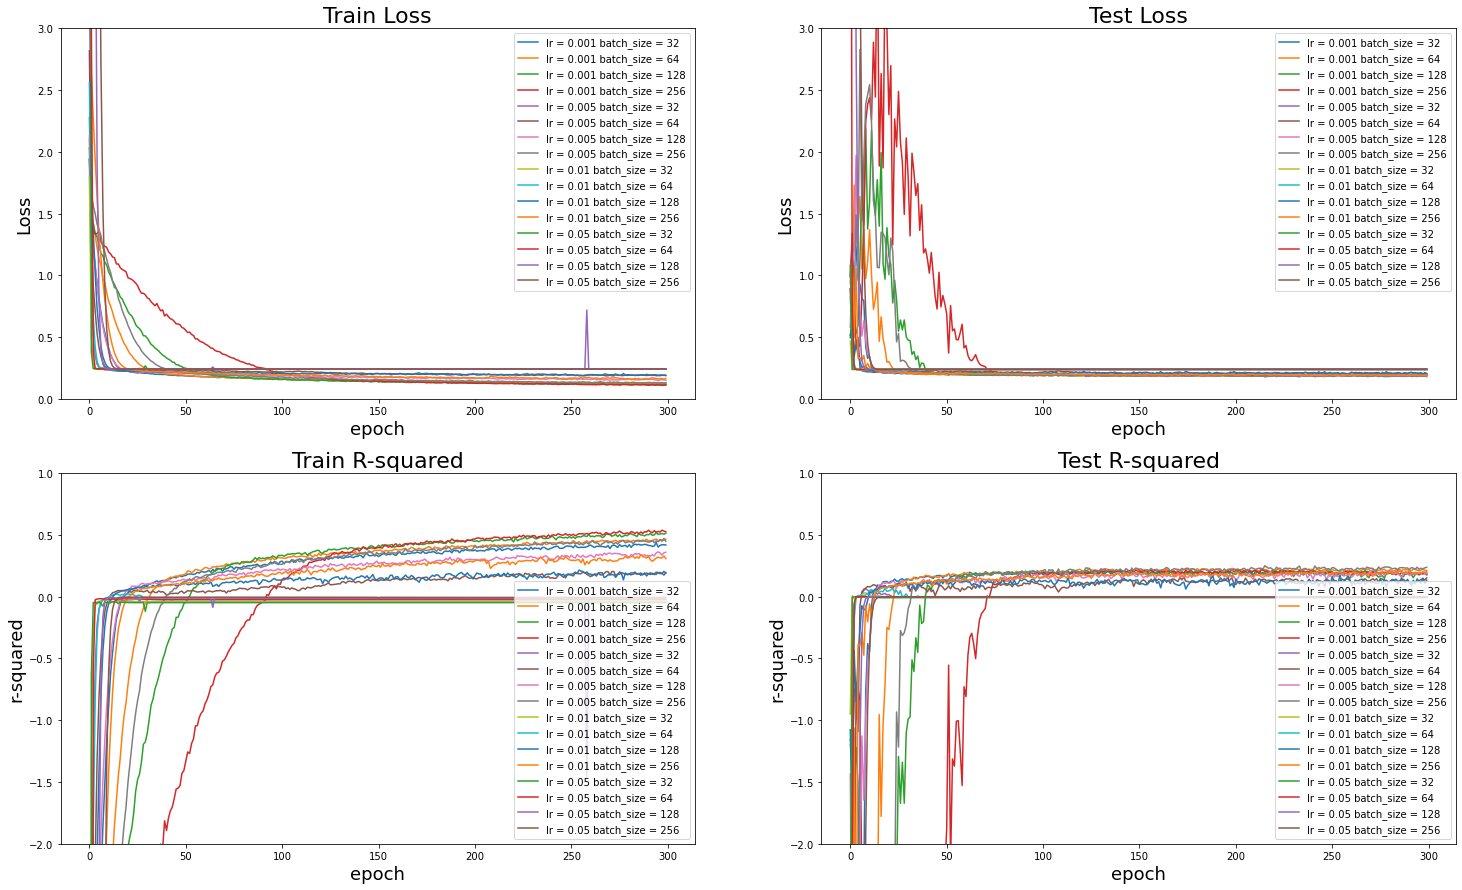

<Figure size 1800x1080 with 0 Axes>

In [16]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [17]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.41842261741754827
0.465842926657446
0.5139582128375281
0.5254890249859097
-0.039333705393399164
0.19429603680035892
0.3597423449178789
0.4487207726005237
-0.040191284105747384
-0.018129875233641134
0.19135548991454482
0.30864683628118444
-0.04790567971233803
-0.024018873220678846
-0.01384264687582252
-0.006013118680677975
___________________

0.18910910238596246
0.21214891069078823
0.17709619277072797
0.17895838757686433
-0.0013845329702075748
0.15264946958763992
0.18348786695676855
0.23861456861566588
-0.0013180453460819308
-0.001664380801428278
0.13434506135844582
0.201492569066955
-0.007798735583401717
-0.0026972020840441147
-0.00017945621199277895
-0.0030686437500009323
___________________

0.12808450455649184
0.12359048793222005
0.11439356903960235
0.11427980288863182
0.24342487513198766
0.1893648359474245
0.1524452309865151
0.13250759071198062
0.2436833572086938
0.243447907105252
0.19360145366322384
0.1663254455163859
0.24522008601952036
0.24473600752733565
0.24412351694420306


### 2 best models

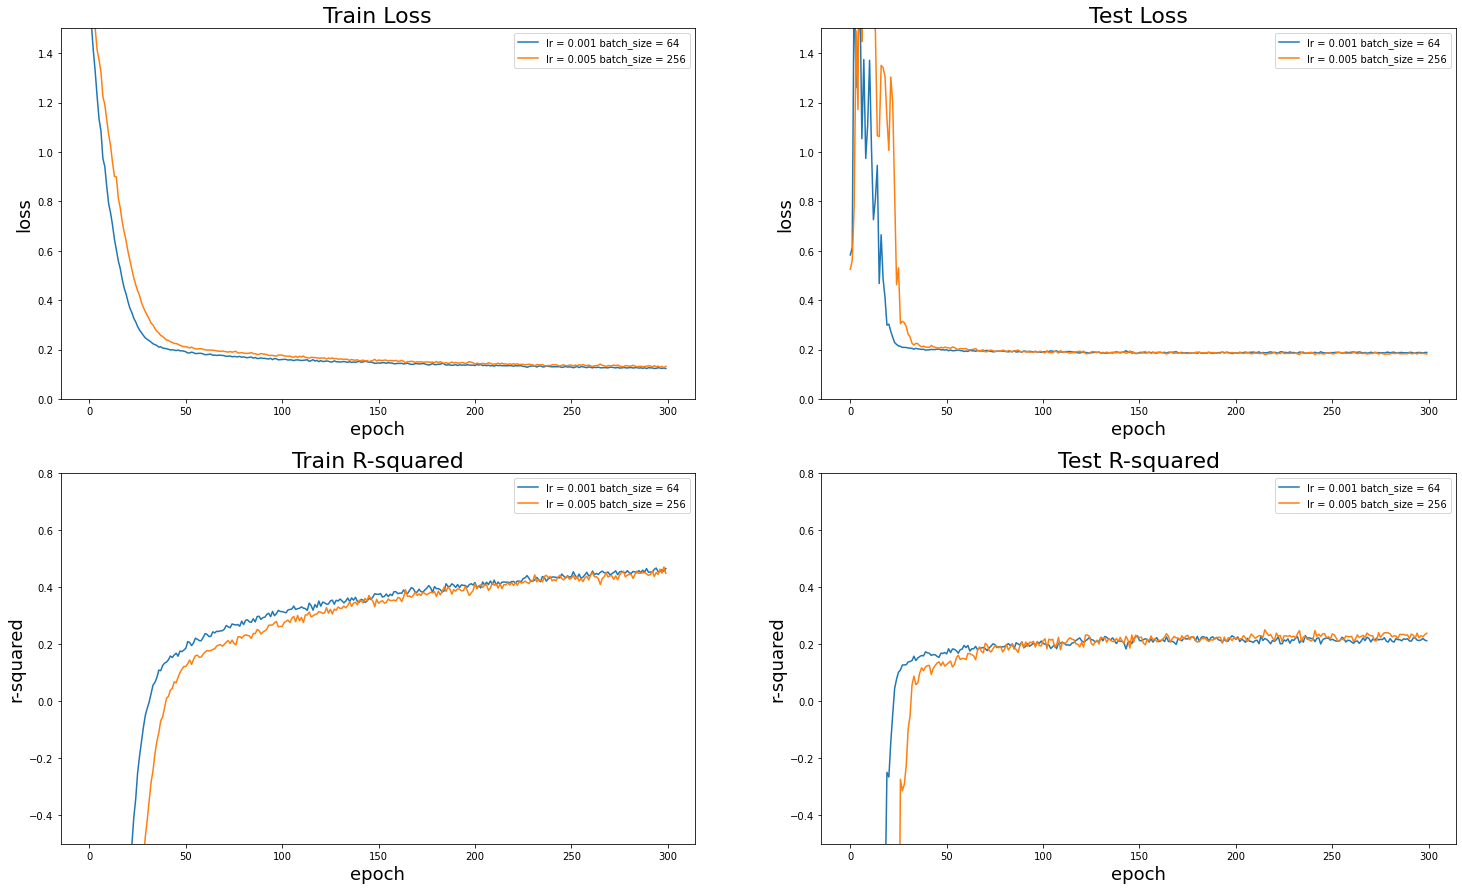

<Figure size 432x288 with 0 Axes>

In [25]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.001 batch_size = 64")
ax1.plot(train_losses_all[7],label="lr = 0.005 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1.5])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.001 batch_size = 64")
ax2.plot(test_losses_all[7],label="lr = 0.005 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1.5])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.001 batch_size = 64")
ax3.plot(train_accs_all[7],label="lr = 0.005 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,0.8])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[1],label="lr = 0.001 batch_size = 64")
ax4.plot(test_accs_all[7],label="lr = 0.005 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,0.8])
plt.show()

## 4.2. Training

In [27]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=4984, shuffle=False)

In [28]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/geno_pubchem_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 3.532417106322753, Accuracy: -13.371275524877033
Test Avg. loss: 0.4899458587169647, Accuracy: -1.120174146319151
################## EPOCH 2 ##################
Train Avg. loss: 1.6376291880240808, Accuracy: -5.899929406133857
Test Avg. loss: 0.5020310878753662, Accuracy: -1.1724712633041627
################## EPOCH 3 ##################
Train Avg. loss: 1.538906808082874, Accuracy: -5.47788720555381
Test Avg. loss: 0.7124836444854736, Accuracy: -2.0831763032008532
################## EPOCH 4 ##################
Train Avg. loss: 1.4421721330055823, Accuracy: -5.091100073050571
Test Avg. loss: 1.0852965116500854, Accuracy: -3.6964732263301245
################## EPOCH 5 ##################
Train Avg. loss: 1.335672832452334, Accuracy: -4.627171603037116
Test Avg. loss: 0.7797383069992065, Accuracy: -2.374211543856543
################## EPOCH 6 ##################
Train Avg. loss: 1.2594852325243828, Accuracy: -4.294704189528657
Tes

Train Avg. loss: 0.20554941395918527, Accuracy: 0.14682069897294384
Test Avg. loss: 0.2038019597530365, Accuracy: 0.11807464947866042
################## EPOCH 48 ##################
Train Avg. loss: 0.20472250554041985, Accuracy: 0.1531407420246711
Test Avg. loss: 0.2016480416059494, Accuracy: 0.12739539044578696
################## EPOCH 49 ##################
Train Avg. loss: 0.2057296933654027, Accuracy: 0.14652683774932365
Test Avg. loss: 0.2016720026731491, Accuracy: 0.12729181006655566
################## EPOCH 50 ##################
Train Avg. loss: 0.20012008780852342, Accuracy: 0.17111688121424584
Test Avg. loss: 0.20354445278644562, Accuracy: 0.11918899537623151
################## EPOCH 51 ##################
Train Avg. loss: 0.2022061315484536, Accuracy: 0.1611102152557154
Test Avg. loss: 0.20486469566822052, Accuracy: 0.1134758392664128
################## EPOCH 52 ##################
Train Avg. loss: 0.19962502003480226, Accuracy: 0.17267030971027106
Test Avg. loss: 0.206802546977

Train Avg. loss: 0.1783550127576559, Accuracy: 0.25886026042073695
Test Avg. loss: 0.1924578994512558, Accuracy: 0.16716454079665777
################## EPOCH 94 ##################
Train Avg. loss: 0.17496375443461615, Accuracy: 0.2722045014004495
Test Avg. loss: 0.19255538284778595, Accuracy: 0.16674269381187734
################## EPOCH 95 ##################
Train Avg. loss: 0.1764106070384001, Accuracy: 0.2659669936012759
Test Avg. loss: 0.19317744672298431, Accuracy: 0.16405075856764018
################## EPOCH 96 ##################
Train Avg. loss: 0.17498938042001846, Accuracy: 0.2731896965132985
Test Avg. loss: 0.19197966158390045, Accuracy: 0.16923404967624667
################## EPOCH 97 ##################
Train Avg. loss: 0.17534871781483674, Accuracy: 0.27043173276148014
Test Avg. loss: 0.19456760585308075, Accuracy: 0.15803510611925753
################## EPOCH 98 ##################
Train Avg. loss: 0.17393194396908468, Accuracy: 0.2765425883491224
Test Avg. loss: 0.19059358537

Train Avg. loss: 0.16272050553025344, Accuracy: 0.3229495181640726
Test Avg. loss: 0.19168215990066528, Accuracy: 0.1705214709691264
################## EPOCH 140 ##################
Train Avg. loss: 0.16073425486683846, Accuracy: 0.3321692428166728
Test Avg. loss: 0.19303448498249054, Accuracy: 0.16466948462646225
################## EPOCH 141 ##################
Train Avg. loss: 0.16550389505349672, Accuracy: 0.3122843209614487
Test Avg. loss: 0.19477464258670807, Accuracy: 0.15713915541869528
################## EPOCH 142 ##################
Train Avg. loss: 0.16224947256537584, Accuracy: 0.3247149328191338
Test Avg. loss: 0.19284145534038544, Accuracy: 0.16550471232100183
################## EPOCH 143 ##################
Train Avg. loss: 0.16287362585083032, Accuracy: 0.3237703016169732
Test Avg. loss: 0.1939850151538849, Accuracy: 0.16055615876052232
################## EPOCH 144 ##################
Train Avg. loss: 0.16570890513368142, Accuracy: 0.31061998906912663
Test Avg. loss: 0.193521

Train Avg. loss: 0.1571467770024752, Accuracy: 0.34485980312479897
Test Avg. loss: 0.1953340768814087, Accuracy: 0.1547182766104992
################## EPOCH 186 ##################
Train Avg. loss: 0.15406371767704302, Accuracy: 0.359136621182589
Test Avg. loss: 0.19252242147922516, Accuracy: 0.16688534595645788
################## EPOCH 187 ##################
Train Avg. loss: 0.15474673494314536, Accuracy: 0.35358921352800615
Test Avg. loss: 0.1910252720117569, Accuracy: 0.17336400033344768
################## EPOCH 188 ##################
Train Avg. loss: 0.15543268200678703, Accuracy: 0.3519236377115137
Test Avg. loss: 0.19093510508537292, Accuracy: 0.17375423460520012
################## EPOCH 189 ##################
Train Avg. loss: 0.15447267078054258, Accuracy: 0.3568106343840939
Test Avg. loss: 0.19703316688537598, Accuracy: 0.14736568086970325
################## EPOCH 190 ##################
Train Avg. loss: 0.15798141081363726, Accuracy: 0.34046693571114905
Test Avg. loss: 0.1930658

Train Avg. loss: 0.1466751804527564, Accuracy: 0.38832614529074766
Test Avg. loss: 0.19894357025623322, Accuracy: 0.1390986416511999
################## EPOCH 232 ##################
Train Avg. loss: 0.14660895615816116, Accuracy: 0.3883539596477672
Test Avg. loss: 0.19018211960792542, Accuracy: 0.17701268886267674
################## EPOCH 233 ##################
Train Avg. loss: 0.1468896240186997, Accuracy: 0.3877417318643963
Test Avg. loss: 0.19211417436599731, Accuracy: 0.1686519285127427
################## EPOCH 234 ##################
Train Avg. loss: 0.14918315534790358, Accuracy: 0.37692955245910265
Test Avg. loss: 0.196000337600708, Accuracy: 0.15183517793103596
################## EPOCH 235 ##################
Train Avg. loss: 0.1508900411427021, Accuracy: 0.37073925110967243
Test Avg. loss: 0.19763970375061035, Accuracy: 0.14474096157012295
################## EPOCH 236 ##################
Train Avg. loss: 0.14590849144718585, Accuracy: 0.3918739779143574
Test Avg. loss: 0.189226046

Train Avg. loss: 0.14270882872052681, Accuracy: 0.40399003750656576
Test Avg. loss: 0.191585510969162, Accuracy: 0.1709396778736637
################## EPOCH 278 ##################
Train Avg. loss: 0.1433886825465239, Accuracy: 0.4026764572322148
Test Avg. loss: 0.22143109142780304, Accuracy: 0.04178706970991497
################## EPOCH 279 ##################
Train Avg. loss: 0.13971770745821488, Accuracy: 0.4178752385255113
Test Avg. loss: 0.19461208581924438, Accuracy: 0.1578425696829392
################## EPOCH 280 ##################
Train Avg. loss: 0.14079291593187895, Accuracy: 0.4138496990247704
Test Avg. loss: 0.1957022100687027, Accuracy: 0.15312522806702644
################## EPOCH 281 ##################
Train Avg. loss: 0.14006148431545648, Accuracy: 0.4145528056621727
Test Avg. loss: 0.19047102332115173, Accuracy: 0.17576242191749103
################## EPOCH 282 ##################
Train Avg. loss: 0.14101064310241967, Accuracy: 0.4131650419227745
Test Avg. loss: 0.2038558125

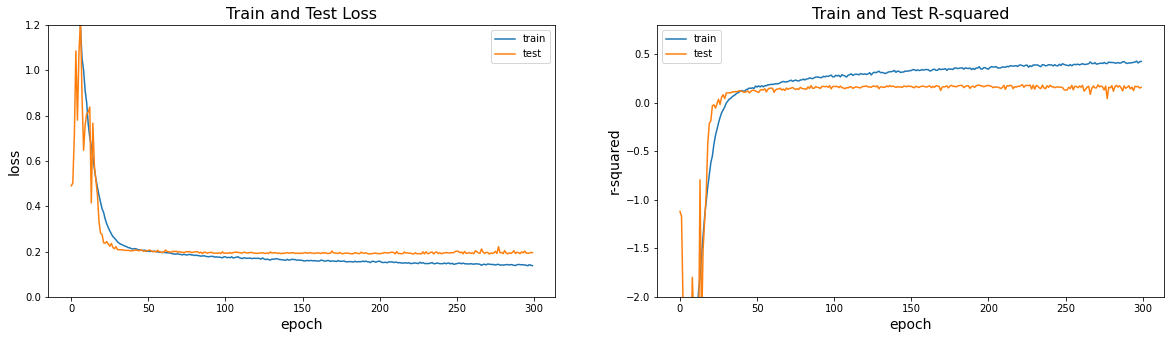

<Figure size 1440x360 with 0 Axes>

In [32]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()
ax1.set_ylim([0,1.2])

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
ax2.set_ylim([-2,0.8])
plt.show()

In [33]:
model = FCNN()
model.load_state_dict(torch.load('../../models/geno_pubchem_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.314333
MSE: 0.18827026
RMSE: 0.4339012
R2 Square 0.18528596759816107 

